# Анализ данных сервиса аренды самокатов

### Описание данных

Имеются данные о некоторых пользователях популярного сервиса аренды самокатов из нескольких городов, а также об их поездках. Чтобы совершать поездки по городу на самокатах, пользователи сервиса пользуются мобильным приложением. Сервисом можно пользоваться либо без подписки, либо с подпиской Ultra. Нужно проанализировать данные и проверить гипотезы, которые могут помочь бизнесу вырасти.

В данных есть информация о пользователях, их поездках и подписках.

1. Таблица «Пользователи» (файл `users_go.csv`):
- `user_id` - уникальный идентификатор пользователя;
- `name` - имя пользователя;
- `age` - возраст;
- `city` - город;
- `subscription_type` - тип подписки (free, ultra).

2. Таблица «Поездки» (файл `rides_go.csv`):
- `user_id` - уникальный идентификатор пользователя;
- `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах);
- `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- `date` - дата совершения поездки.

3. Таблица «Подписки» (файл `subscriptions_go.csv`):
- `subscription_type` - тип подписки;
- `minute_price` - стоимость одной минуты поездки по данной подписке;
- `start_ride_price` - стоимость начала поездки;
- `subscription_fee` - стоимость ежемесячного платежа.

### Цели исследования
- Проанализировать данные о пользователях сервиса и их поездках. Сделать акцент на сравнении пользователей с подпиской и без подписки.
- Проверить гипотезы:
    - Пользователи с подпиской тратят больше времени на поездки.
    - Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального с точки зрения износа самоката.
    - Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
- Ответить на вопросы:
    - Какой тест понадобится для проверки гипотезы, что количество обращений в техподдержку значимо снизилось после обновления серверов, с которыми взаимодействует мобильное приложение?
    - Какое минимальное количество промокодов нужно разослать, чтобы получить  примерно равную 5 % вероятность не выполнить план акции, в рамках которой как минимум 100 существующих клиентов должны продлить подписку?
    - Какая вероятность того, что push-уведомление в мобильном приложении откроют не более 399,5 тыс. пользователей?

### Импорты

In [1]:
# импорт библиотек, модулей и отдельных функций
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from math import sqrt, floor, ceil

## Загрузка данных

### Получение данных

In [2]:
# загрузка таблиц из CSV файлов
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    # файлы на локальном компьютере
    try:
        users = pd.read_csv('datasets/users_go.csv')
        rides = pd.read_csv('datasets/rides_go.csv')
        subscriptions = pd.read_csv('datasets/subscriptions_go.csv')
    # файлы на внешнем сервере
    except:
        users = pd.read_csv('https://<LINK_REMOVED>/datasets/users_go.csv')
        rides = pd.read_csv('https://<LINK_REMOVED>/datasets/rides_go.csv')
        subscriptions = pd.read_csv('https://<LINK_REMOVED>/datasets/subscriptions_go.csv')

### Обзор данных

#### Таблица «Пользователи»

In [3]:
# общая информация о таблице
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


- Таблица содержит 1565 записей. 
- Пропущенные значения отсутствуют.
- Типы данных соответствуют их характеру.

Выведем первые строки таблицы.

In [4]:
# первые 5 строк таблицы
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


#### Таблица «Поездки»

In [5]:
# общая информация о таблице
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


- Таблица содержит 18068 записей. 
- Пропущенные значения отсутствуют.
- Тип данных в столбце `date` текстовый, его нужно будет преобразовать в тип даты. В остальных столбцах типы данных соответствуют их характеру.

Выведем первые строки таблицы.

In [6]:
# первые 5 строк таблицы
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


#### Таблица «Подписки»

In [7]:
# общая информация о таблице
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Таблица содержит всего 2 записи. Поэтому её можно вывести полностью.

In [8]:
# вся таблица
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


- Пропущенные значения отсутствуют.
- Типы данных соответствуют их характеру.

### Вывод

1. Качество полученных данных высокое:
   - Пропущенные значения отсутствуют.
   - Имена столбцов во всех таблицах соответствуют общепринятому стилю именования.
   - Типы данных в столбцах таблиц соответствуют их характеру (кроме столбца с датой в таблице «Поездки»).
<br/><br/>
2. Обнаруженные проблемы, которые следует исправить:
   - В столбце `date` таблицы «Поездки» тип данных текстовый, нужно будет изменить тип данных в этом столбце на тип даты-времени.

## Предобработка данных

### Преобразование типа данных даты в таблице «Поездки»

Приведём столбец `date` таблицы «Поездки» к типу даты-времени pandas.

In [9]:
# преобразуем тип данных в datetime64, используя известный формат записи даты
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
# проверяем типы данных в таблице
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

### Добавление месяца в таблицу «Поездки»

Убедимся, что в таблице содержатся данные за один год. Тогда категоризация по месяцу совершения поездки будет однозначна.

In [11]:
# характеристики распределения значений в столбце
rides['date'].describe(datetime_is_numeric=True).to_frame()

,date
count,18068
mean,2021-06-30 19:47:21.266327296
min,2021-01-01 00:00:00
25%,2021-04-02 00:00:00
50%,2021-06-30 00:00:00
75%,2021-09-28 00:00:00
max,2021-12-30 00:00:00


Добавим в таблицу «Поездки» новый столбец с номером месяца совершения поездки.

In [12]:
# создаём столбец 'month', содержащий номер месяца
rides['month'] = rides['date'].dt.month

Выведем первые строки таблицы.

In [13]:
# первые 5 строк таблицы
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Обработка пропущенных значений и дубликатов

#### Таблица «Пользователи»

На этапе знакомства с данными пропущенные значения не были обнаружены. Однако в данных могут быть неявные пропуски, заполненные плейсхолдерами.

Для поиска неявных пропусков исследуем уникальные значения в столбцах таблицы.

In [14]:
# количество уникальных значений в столбцах таблицы
users.nunique()

user_id              1534
name                  194
age                    29
city                    8
subscription_type       2
dtype: int64

По тому, что в столбце `user_id` количество уникальных значений меньше, чем число записей, можно предположить, что в таблице могут быть дубликаты.

В остальных столбцах количество уникальных значений не очень велико, поэтому можно их непосредственно исследовать. Для вывода списка уникальных значений в интересующих столбцах таблицы создадим функцию `list_unique_values()`.

In [15]:
def list_unique_values(data, columns=None):
    """
    Для каждого из указанных столбцов датафрейма выводит 
    отсортированный список уникальных значений в этом столбце.
    """
    if columns is None:
        columns = data.columns
    for col in columns:
        print(f'Уникальные значения в столбце \'{col}\':\n'
              f'{data[col].sort_values().unique().tolist()}')
        print()

In [16]:
# уникальные значения в интересующих столбцах таблицы
list_unique_values(users, users.columns.drop('user_id'))

Уникальные значения в столбце 'name':
['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра', 'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина', 'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий', 'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина', 'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём', 'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия', 'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника', 'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад', 'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод', 'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей', 'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила', 'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий', 'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена', 'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар', 'Злата', 'Иван', 'Игнат', 'Игорь', 'Ильдар', 'Илья', 'Инна', 'Ирина', 'Ками

Неявные пропуски (плейсхолдеры) и аномальные значения не обнаружены.

Найдём количество полных дубликатов строк таблицы.

In [17]:
# количество строк-дубликатов
users.duplicated().sum()

31

Возможная причина появления в таблице строк-дубликатов - ошибки при выгрузке из базы данных.

Удалим из таблицы строки-дубликаты.

In [18]:
# удаление строк-дубликатов
users = users.drop_duplicates()

In [19]:
# проверка:
# количество строк-дубликатов
users.duplicated().sum()

0

Также проверим, не повторяются ли значения уникального идентификатора пользователя в столбце `user_id`.

In [20]:
# количество дубликатов с одинаковым user_id
users.duplicated(subset=['user_id']).sum()

0

Дубликатов в таблице не осталось.

#### Таблица «Поездки»

На этапе знакомства с данными пропущенные значения не были обнаружены.


Проверим, не встречается ли в числовых столбцах `distance` и `duration` аномальное значение `0`, которое может быть заполнителем пропусков.

In [21]:
# числовые характеристики данных в столбцах
rides.describe(include=['float64'])

,distance,duration
count,18068.000000,18068.000000
mean,3070.659976,17.805011
std,1116.831209,6.091051
min,0.855683,0.500000
25%,2543.226360,13.597563
50%,3133.609994,17.678395
75%,3776.222735,21.724800
max,7211.007745,40.823963


Нули не обнаружены, данные адекватны.

Проверим таблицу на наличие полных дубликатов строк.

In [22]:
# количество строк-дубликатов
rides.duplicated().sum()

0

Дубликаты не обнаружены.

### Задание столбца индекса в таблицах «Пользователи» и «Подписки»

В таблице «Пользователи» столбец `user_id` содержит уникальный идентификатор пользователя. Поскольку эти значения не повторяются, можно сделать этот столбец индексом таблицы.

В таблице «Подписки» ключом является название типа подписки в столбце `subscription_type`. Сделаем его индексом таблицы.

In [23]:
# устанавливаем столбец 'user_id' индексом таблицы users
users = users.set_index('user_id')
# устанавливаем 'subscription_type' столбец индексом таблицы subscriptions
subscriptions = subscriptions.set_index('subscription_type')

Проверим результат.

In [24]:
# первые 5 строк таблицы
users.head()

,name,age,city,subscription_type
user_id,,,,
1,Кира,22,Тюмень,ultra
2,Станислав,31,Омск,ultra
3,Алексей,20,Москва,ultra
4,Константин,26,Ростов-на-Дону,ultra
5,Адель,28,Омск,ultra


In [25]:
# вся таблица
subscriptions

,minute_price,start_ride_price,subscription_fee
subscription_type,,,
free,8,50,0
ultra,6,0,199


### Вывод

В результате **предобработки** данные подготовлены для анализа:
- **Изменён тип данных** в столбце `date` таблицы «Поездки», содержащий дату совершения поездки. Это позволит производить операции с датами и извлекать компоненты даты методами библиотеки pandas.
- В таблице «Поездки» **добавлен новый столбец** `month` с номером месяца совершения поездки. Это позволит удобно группировать поездки по месяцу из совершения.
- **Удалены строки-дубликаты** в таблице «Пользователи». Они не несут полезной информации, а только могут исказить результаты анализа данных. Возможная причина их появления - ошибки при выгрузке из базы данных.
- В таблицах «Пользователи» и «Подписки» **установлены столбцы индекса**, являющиеся ключами в этих таблицах:
    - столбец `user_id` в таблице «Пользователи»,
    - столбец `subscription_type` в таблице «Подписки».

## Исследовательский анализ данных

При проведении исследовательского анализа данных будут полезны следующие функции:
- `column_stat(data, columns)` - для вывода параметров распределения значений в столбцах,
- `count_and_share(data, column)` - для вывода таблицы с количеством и долей записей для каждого из уникальных значений в столбце.

In [26]:
def column_stat(data, columns=None):
    """
    Возвращает параметры распределения значений в столбцах: 
    кол-во объектов, минимум, среднее, медиана, максимум.
    """
    if columns is None:
        columns = data.columns
    stat = (data[columns]
            .agg(['count', 'min', 'mean', 'std', 'median', 'max'])
            .round(2)
           )
    # если объект Series, то преобразуем его в DataFrame
    if isinstance(stat, pd.Series):
        stat = stat.to_frame()
    # транспонируем
    stat = stat.T
    # количество - всегда целое число
    stat['count'] = stat['count'].astype(int, errors='ignore')
    # название индекса
    stat.index.name = 'column'
    
    return stat

In [27]:
def count_and_share(data, column):
    """
    Возвращает таблицу с количеством и долей записей
    для каждого из уникальных значений в столбце.
    """
    # группируем данные по значению параметра,
    # считаем кол-во записей и их долю
    table = (
        data
         .groupby(column)[column]
         .agg(['count', lambda x: x.count()/len(data) * 100])
         .round(4)
         .sort_values('count', ascending=False)
         .rename(columns={'<lambda_0>': 'percentage'})
    )
    return table

### Частота встречаемости городов

Информация о городе, в котором находится пользователь, содержится в столбце `city` таблицы «Пользователи».

Изучим распределение пользователей по городам.

In [28]:
# формируем и оформляем таблицу
(count_and_share(users, 'city')
 .rename_axis('город')
 .rename(columns={'count':'кол-во пользователей',
                  'percentage': 'доля пользователей (%)'
                 }
        )
 .round(2)
)

,кол-во пользователей,доля пользователей (%)
город,,
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


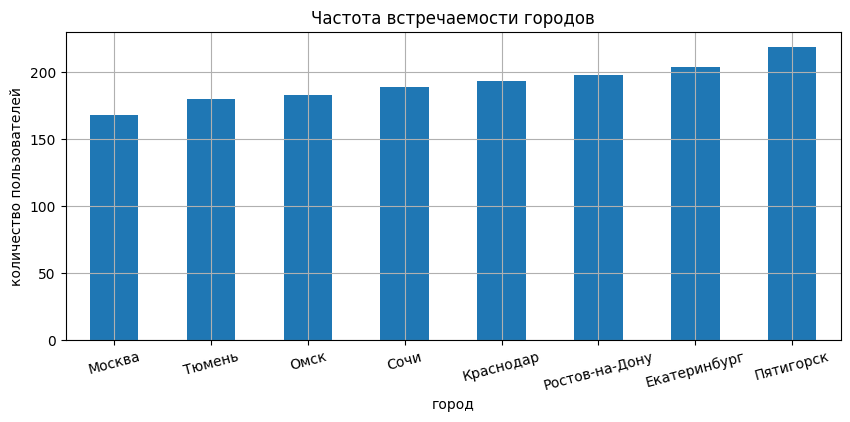

In [29]:
# строим столбчатую диаграмму
(users['city']
 .value_counts(ascending=True)
 .plot.bar(figsize=(10, 4), grid=True, rot=15)
)
plt.title('Частота встречаемости городов')
plt.xlabel('город')
plt.ylabel('количество пользователей')
plt.show()

Распределение доли пользователей по городам визуализируем с помощью круговой диаграммы.

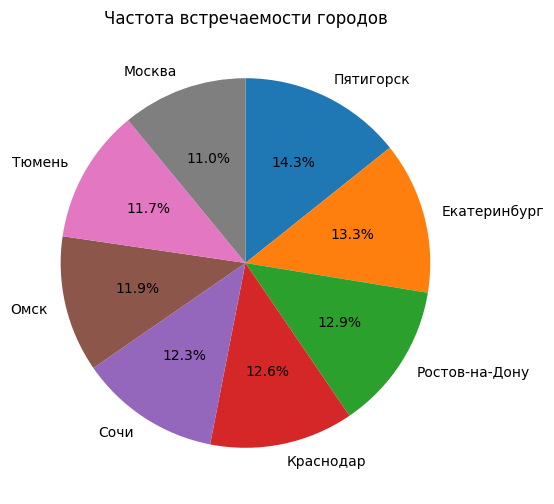

In [30]:
# строим и оформляем круговую диаграмму
(users['city']
 .value_counts()
 .plot.pie(figsize=(6, 6), startangle=90, counterclock=False, autopct='%.1f%%')
)
plt.title('Частота встречаемости городов')
plt.ylabel('')
plt.show()

В выборке представлены 8 городов, среди которых есть мегаполис - Москва, крупные города-региональные центры (Екатеринбург, Ростов-на-Дону, Омск, Краснодар - с населением более 1 млн чел., Тюмень - чуть менее 850 тыс. чел.), крупный город Сочи (более 450 тыс. чел.) и относительно небольшой Пятигорск (140 тыс. чел.).

Распределение пользователей в выборке по городам примерно равномерное: доли городов изменяются от ≈11 % (Москва) до ≈14 % (Пятигорск).

Выборку можно считать репрезентативной, если число пользователей из определённого города в выборке пропорциональна общему числу пользователей сервиса в этом городе.

### Соотношение пользователей с подпиской и без подписки

Информация о типе подписки содержится в столбце `subscription_type` таблицы «Пользователи».

Изучим распределение пользователей по типу подписки.

In [31]:
# формируем и оформляем таблицу
(count_and_share(users, 'subscription_type')
 .rename_axis('тип подписки')
 .rename(columns={'count':'кол-во пользователей',
                  'percentage': 'доля пользователей (%)'
                 }
        )
 .round(2)
)

,кол-во пользователей,доля пользователей (%)
тип подписки,,
free,835,54.43
ultra,699,45.57


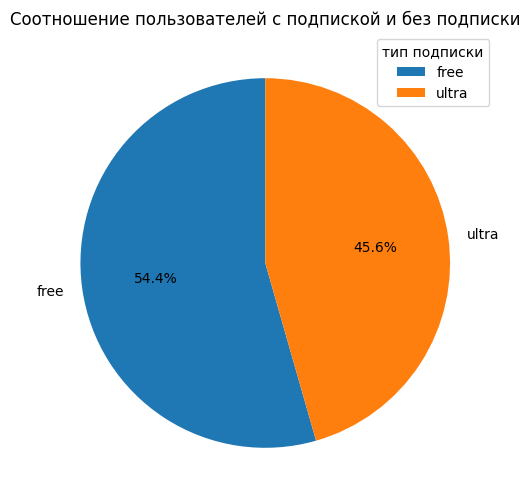

In [32]:
# строим и оформляем круговую диаграмму
(users['subscription_type']
 .value_counts()
 .plot.pie(figsize=(6, 6), startangle=90, autopct='%.1f%%')
)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('')
plt.legend(title='тип подписки')
plt.show()

Пользователи с подпиской и без подписки представлены в выборке не одинаково, однако их доли отличаются не сильно. Доля пользователей с подпиской ("ultra") составляет ≈46 %, без подписки ("free") ≈54 % пользователей.

Исследуем распределение пользователей с подпиской по городам. Это важно, чтобы понять, можно ли считать выборку репрезентативной.

In [33]:
# формируем сводную таблицу
city_stat = (
    users
    .pivot_table(
        index='city', 
        columns='subscription_type', 
        values='name', 
        aggfunc='count',
    )
)
# считаем доли пользователей и добавляем в таблицу
city_stat = (
    city_stat
     .join(
         city_stat
          .transform(lambda x: x / x.sum() * 100, axis=1),
         rsuffix='_share'
     )
    .sort_values('free_share')
)
# общее число пользователей
city_stat['total'] = city_stat['free'] + city_stat['ultra']
# оформляем и выводим таблицу
(city_stat
     .round(2)
     .rename_axis('город', axis=0)
     .rename_axis(None, axis=1)
     .rename(columns={
         'free':'кол-во пользователей без подписки',
         'ultra': 'кол-во пользователей с подпиской',
         'free_share':'доля пользователей без подписки (%)',
         'ultra_share': 'доля пользователей с подпиской (%)',
         'total':'суммарное кол-во пользователей',
         }
     )
)

,кол-во пользователей без подписки,кол-во пользователей с подпиской,доля пользователей без подписки (%),доля пользователей с подпиской (%),суммарное кол-во пользователей
город,,,,,
Москва,84,84,50.00,50.00,168
Омск,92,91,50.27,49.73,183
Тюмень,98,82,54.44,45.56,180
Сочи,103,86,54.50,45.50,189
Екатеринбург,112,92,54.90,45.10,204
Ростов-на-Дону,109,89,55.05,44.95,198
Пятигорск,125,94,57.08,42.92,219
Краснодар,112,81,58.03,41.97,193


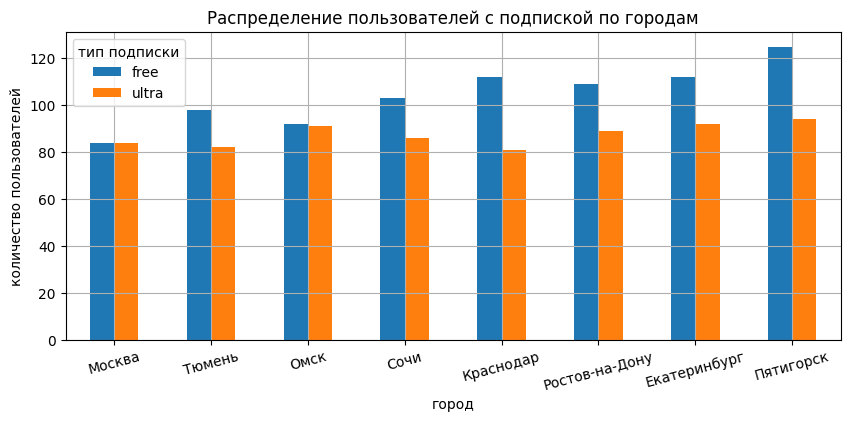

In [34]:
# строим столбчатую диаграмму
(city_stat
 .sort_values('total')
 .plot.bar(y=['free', 'ultra'], figsize=(10, 4), grid=True, rot=15, stacked=False)
)
plt.title('Распределение пользователей с подпиской по городам')
plt.xlabel('город')
plt.ylabel('количество пользователей')
plt.legend(title='тип подписки')
plt.show()

Число пользователей с подпиской в каждом городе не превышает числа пользователей без подписки. 

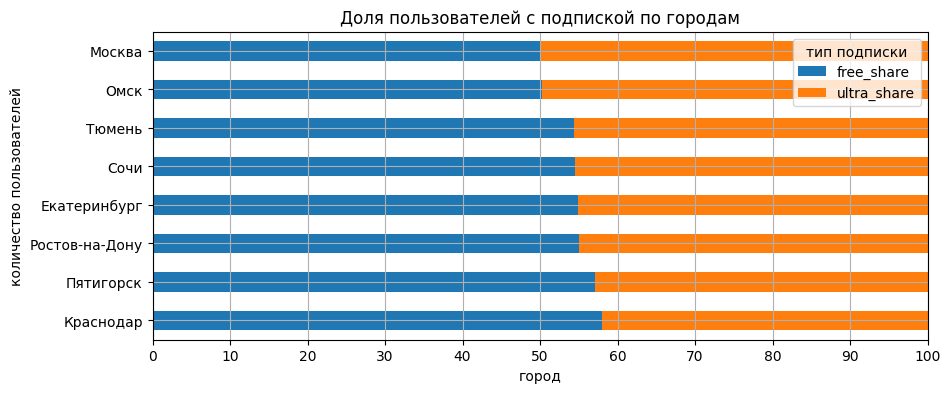

In [35]:
# строим столбчатую диаграмму
(city_stat
 .sort_values('ultra_share')
 .plot.barh(y=['free_share', 'ultra_share'], figsize=(10, 4), grid=True, rot=0, stacked=True)
)
plt.xlim(0, 100)
plt.xticks(range(0, 101, 10))
plt.title('Доля пользователей с подпиской по городам')
plt.xlabel('город')
plt.ylabel('количество пользователей')
plt.legend(title='тип подписки')
plt.show()

В некоторых городах доли пользователей с подпиской и без подписки одинаковы (Москва) или почти одинаковы (Омск). В  других (Тюмень, Сочи, Екатеринбург, Ростов-на-Дону) доля пользователей с подпиской составляет примерно 45 %. Минимальная доля пользователей с подпиской в Пятигорске (43 %) и Краснодаре (42 %).

Как было установлено ранее, в целом а выборке доля пользователей с подпиской составляет ≈45,6 %. Таким образом, отклонение от средней доли для отдельных городов лежит в пределах ± 5 %. Поэтому выборку можно считать достаточно репрезентативной.

### Возраст пользователей

Получим характеристики распределения пользователей по возрасту (столбец `age` таблицы «Пользователи»).

In [36]:
# характеристики распределения значений в столбце
column_stat(users, 'age')

,count,min,mean,std,median,max
column,,,,,,
age,1534,12.0,24.9,4.57,25.0,43.0


Построим гистограмму распределения пользователей по возрасту в диапазоне от минимального до максимального значения, задав число корзин таким, чтобы было видно значение частоты для каждого возраста.

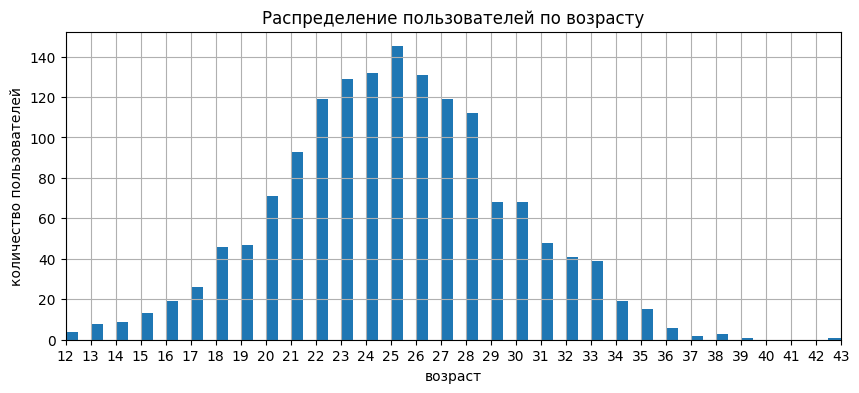

In [37]:
# строим и оформляем гистограмму
users.hist('age', bins=62, range=(12, 43), figsize=(10, 4))
plt.xlim((12, 43))
plt.xticks(range(12, 44, 1))
plt.title('Распределение пользователей по возрасту')
plt.xlabel('возраст')
plt.ylabel('количество пользователей')
plt.show()

Распределение пользователей по возрасту похоже на нормальное. Средний возраст пользователей составляет 25 лет.

### Расстояние, которое пользователь преодолел за одну поездку

Расстояние в метрах, которое пользователь проехал за одну поездку, содержится в столбце `distance` таблицы «Поездки».

Получим характеристики распределения поездок по расстоянию.

In [38]:
# характеристики распределения значений в столбце
column_stat(rides, 'distance')

,count,min,mean,std,median,max
column,,,,,,
distance,18068,0.86,3070.66,1116.83,3133.61,7211.01


Построим гистограмму распределения поездок по расстоянию в диапазоне от минимального до максимального значения, задав число корзин таким, чтобы размер одной корзины был равен 50 м.

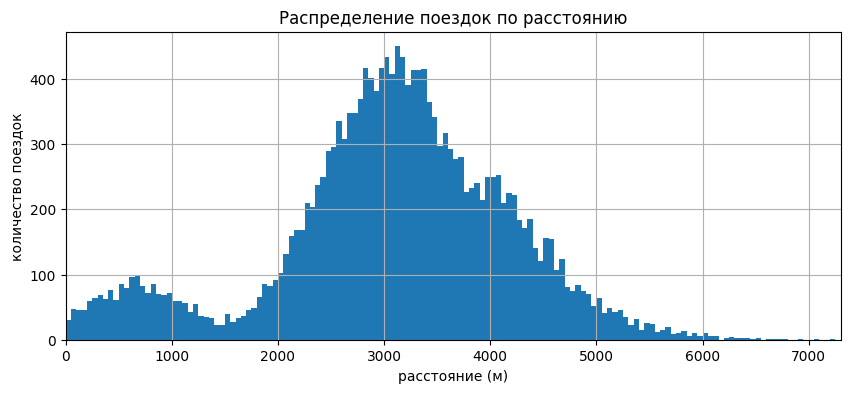

In [39]:
# строим и оформляем гистограмму
rides.hist('distance', bins=146, range=(0, 7300), figsize=(10, 4))
plt.xlim((0, 7300))
plt.title('Распределение поездок по расстоянию')
plt.xlabel('расстояние (м)')
plt.ylabel('количество поездок')
plt.show()

Распределение поездок по расстоянию имеет вид суммы 2-х или 3-х нормальных. Основной максимум распределения находится около 3 км. Есть также второй максимум около 600-700 м, соответствующий коротким поездкам, а также слабо выраженный «горб» справа от основного максимума, соответствующих более длинным поездкам около 4 км. Максимальное расстояние поездки составляет ≈7,2 км.

### Продолжительность поездок

Продолжительность поездок в минутах, которое пользователь проехал за одну поездку, содержится в столбце `distance` таблицы «Поездки».

Получим характеристики распределения продолжительности поездок.

In [40]:
# характеристики распределения значений в столбце
column_stat(rides, 'duration')

,count,min,mean,std,median,max
column,,,,,,
duration,18068,0.5,17.81,6.09,17.68,40.82


Построим гистограмму продолжительности длительности поездок в диапазоне от минимального до максимального значения, задав число корзин таким, чтобы размер одной корзины был равен 0,5 минут.

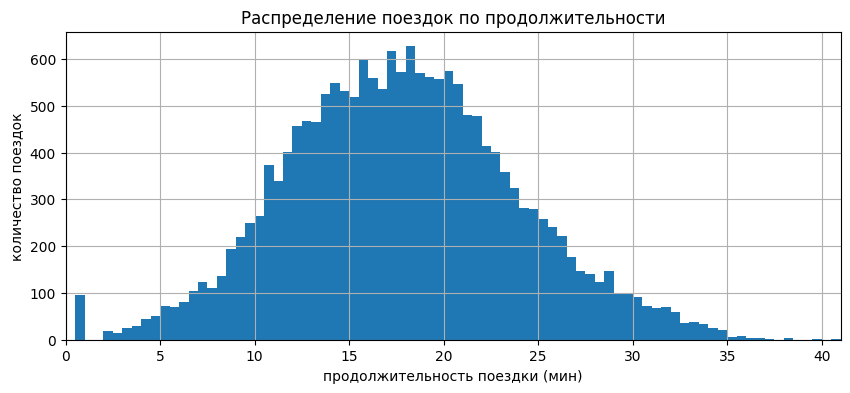

In [41]:
# строим и оформляем гистограмму
rides.hist('duration', bins=82, range=(0, 41), figsize=(10, 4))
plt.xlim((0, 41))
plt.title('Распределение поездок по продолжительности')
plt.xlabel('продолжительность поездки (мин)')
plt.ylabel('количество поездок')
plt.show()

Распределение поездок по продолжительности похоже на нормальное с центром около 17-18 минут. Подавляющее большинство поездок по продолжительности попадают в диапазон от 2 до 35 минут.

На гистограмме выделяется аномальный пик на значении продолжительности поездки 0,5 минут. Для более подробного его изучения построим фрагмент гистограммы в диапазоне продолжительности поездки от 0 до 5 минут.

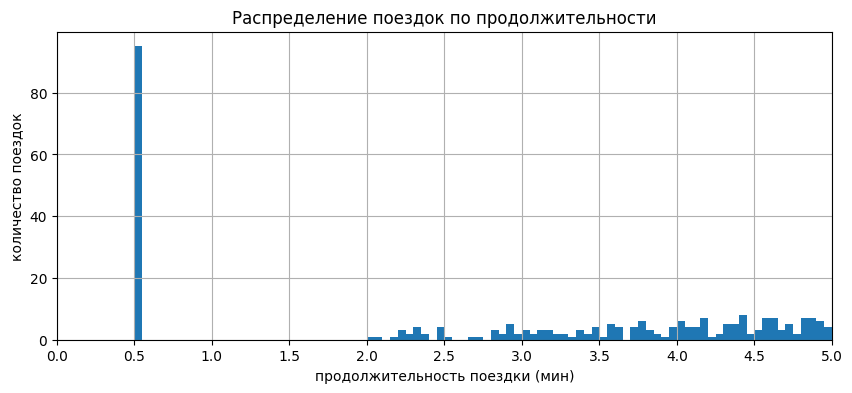

In [42]:
# строим и оформляем гистограмму
rides.hist('duration', bins=100, range=(0, 5), figsize=(10, 4))
plt.xlim((0, 5))
plt.xticks(np.arange(0, 5.1, 0.5))
plt.title('Распределение поездок по продолжительности')
plt.xlabel('продолжительность поездки (мин)')
plt.ylabel('количество поездок')
plt.show()

Аномальные поездки длительностью 0,5 минут - это, вероятно, случаи, когда пользователь отказался от совершения поездки. Посмотрим, какая длина у таких поездок.

In [43]:
# характеристики распределения значений в столбце
column_stat(rides.query('duration < 1'), 'distance')

,count,min,mean,std,median,max
column,,,,,,
distance,95,4030.31,5113.18,658.25,5052.77,7211.01


Чтобы преодолеть за 0,5 минуты расстояние более 4 км, надо ехать со скоростью более 8 км/мин = 480 км/ч. Очевидно, что самокат такую скорость развить в принципе не может. Возможно, при быстром завершении поездки в приложении происходит сбой геолокации. Надо обратить на это внимание разработчиков приложения. 

Таких поездок мало - всего 95. Поэтому существенного влияния на статистику поездок они не оказывают. Кроме того, за эти поездки также начислялась плата. Оставим их в данных.

Также по гистограмме видно отсутствие поездок с продолжительностью менее 2 минут, за исключением аномальных. Вероятно, это минимальная продолжительность одной поездки, которую позволяет сервис.

### Средняя скорость поездок

Для выявления потенциальных аномалий исследуем среднюю скорость поездок. Добавим в таблицу «Поездки» столбец со значением средней скорости поездки, которая определяется как пройденное расстояние, делённое на продолжительность поездки. Также переведём скорость в единицы "км/ч".

In [44]:
# добавляем столбец в таблицу
rides['avg_speed'] = rides['distance'] / rides['duration'] / 1000 * 60

Получим характеристики распределения средней скорости поездок, за исключением аномальных.

In [45]:
# характеристики распределения значений в столбце
column_stat(rides.query('duration > 1'), 'avg_speed')

,count,min,mean,std,median,max
column,,,,,,
avg_speed,17973,0.01,10.61,3.97,10.23,25.39


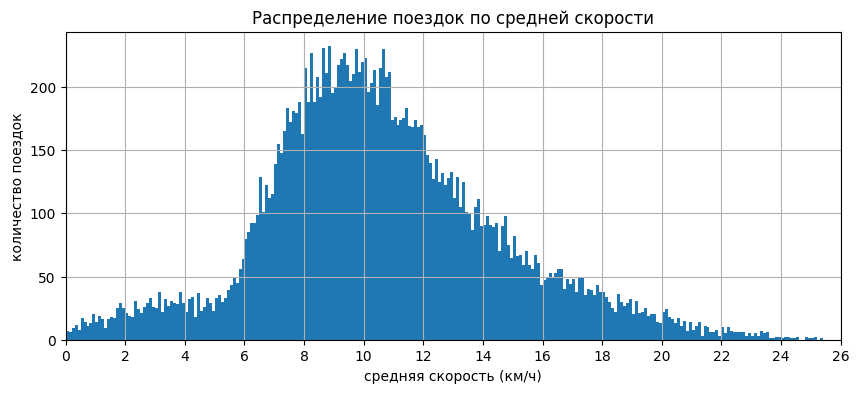

In [46]:
# строим и оформляем гистограмму
(rides
 .query('duration > 1')
 .hist('avg_speed', bins=260, range=(0, 26), figsize=(10, 4))
)
plt.xlim((0, 26))
plt.xticks(range(0, 27, 2))
plt.title('Распределение поездок по средней скорости')
plt.xlabel('средняя скорость (км/ч)')
plt.ylabel('количество поездок')
plt.show()

Максимальная средняя скорость поездки составляет чуть более 25 км/ч, что вполне реалистично. Большинство поездок совершается со средней скоростью от 6 до 16 км/ч, типичная скорость около 10 км/ч.

Левый хвост распределения доходит до нуля. Получается, в данных есть аномально медленные поездки. Для выявления потенциальных аномалий построим диаграмму рассеяния, по которой можно оценить совместное распределение двух величин - пройденного расстояния и продолжительности поездки.

In [47]:
# характеристики распределения значений в столбце
column_stat(rides, ['duration', 'distance'])

,count,min,mean,std,median,max
column,,,,,,
duration,18068,0.50,17.81,6.09,17.68,40.82
distance,18068,0.86,3070.66,1116.83,3133.61,7211.01


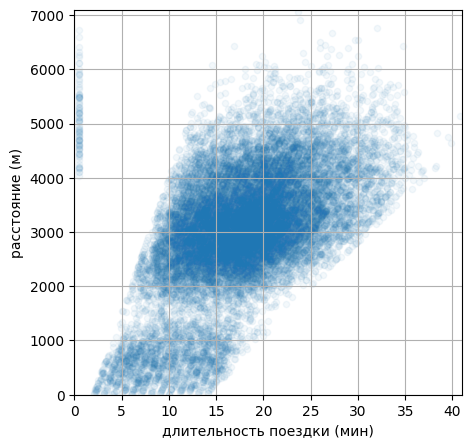

In [48]:
# строим диаграмму рассеяния
# в выбранном диапазоне значений
(rides
 .plot.scatter(x='duration', y='distance', 
               xlim=(0, 41), ylim=(0, 7100),
               xlabel='длительность поездки (мин)', ylabel='расстояние (м)',
               alpha=0.05, grid=True, figsize=(5, 5)
              )
);

Видно, что короткие поездки на расстояния менее 1,5 км образуют отдельный кластер. Причем среди них есть аномально медленные. Изучим их поподробнее, построив фрагмент диаграммы для поездок короче 100 м.

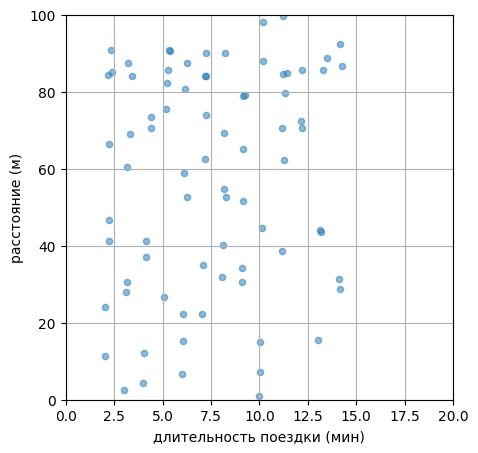

In [49]:
# строим диаграмму рассеяния
# в выбранном диапазоне значений
(rides
 .plot.scatter(x='duration', y='distance', 
               xlim=(0, 20), ylim=(0, 100),
               xlabel='длительность поездки (мин)', ylabel='расстояние (м)',
               alpha=0.5, grid=True, figsize=(5, 5)
              )
);

Действительно, некоторые поездки кажутся аномально медленными: пройденное расстояние меньше 20 м при продолжительности более 5 минут кажется странным. Посмотрим на топ самых медленных и коротких поездок.

In [50]:
# сортируем таблицу и выводим первые строки
rides.sort_values(['avg_speed', 'distance']).head()

,user_id,distance,duration,date,month,avg_speed
11555,1069,0.855683,10.001902,2021-01-31,1,0.005133
7841,796,7.097072,10.026614,2021-11-26,11,0.042469
9541,925,2.570787,3.011018,2021-10-19,10,0.051228
13690,1223,4.329506,4.008958,2021-05-22,5,0.064797
8658,861,6.784447,6.015656,2021-07-21,7,0.067668


Среди кажущихся аномально медленными поездок нет заметных выбросов, скорость, расстояние и продолжительность изменяются плавно. Поэтому их лучше сохранить в данных. Видимо, некоторые пользователи просто стояли на месте. Возможно, они столкнулись с техническими проблемами или препятствиями для движения. Либо это начинающие пользователи, которые пока только пробуют сервис и не освоили в достаточной мере использование приложения.  

### Среднее расстояние и средняя продолжительность поездки пользователей

Сгруппируем данные о поездках по пользователям и найдём распределения среднего расстояния и средней продолжительности поездки пользователей.

In [51]:
# формируем сводную таблицу
user_stat = rides.pivot_table(index='user_id', values=['distance','duration'])

In [52]:
# характеристики распределения значений в столбцах
column_stat(user_stat)

,count,min,mean,std,median,max
column,,,,,,
distance,1534,1630.79,3077.30,327.62,3090.86,4287.52
duration,1534,11.16,17.93,1.97,17.90,26.14


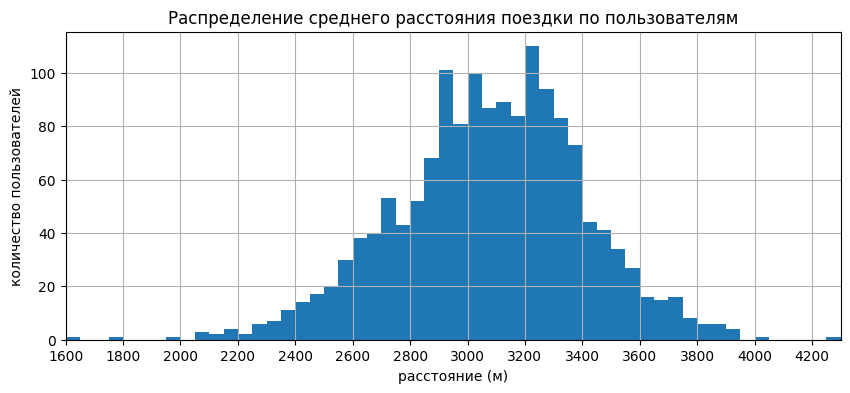

In [53]:
# строим и оформляем гистограмму
user_stat.hist('distance', bins=54, range=(1600, 4300), figsize=(10, 4))
plt.xlim((1600, 4300))
plt.xticks(range(1600, 4300, 200))
plt.title('Распределение среднего расстояния поездки по пользователям')
plt.xlabel('расстояние (м)')
plt.ylabel('количество пользователей')
plt.show()

Распределение средней длины поездки по пользователям похоже на нормальное, только немного скошенное влево. Похоже, это влияние повышенной доли коротких поездок. В среднем по пользователям средняя длина поездки составляет ≈3,1 км.

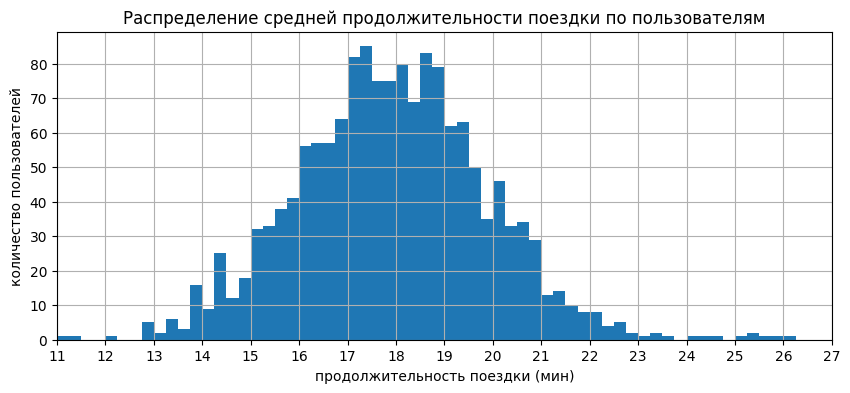

In [54]:
# строим и оформляем гистограмму
user_stat.hist('duration', bins=64, range=(11, 27), figsize=(10, 4))
plt.xlim((11, 27))
plt.xticks(range(11, 28, 1))
plt.title('Распределение средней продолжительности поездки по пользователям')
plt.xlabel('продолжительность поездки (мин)')
plt.ylabel('количество пользователей')
plt.show()

Распределение средней продолжительности поездки по пользователям также похоже на нормальное. В среднем по пользователям средняя продолжительность поездки составляет ≈18 минут.

### Выводы

В результате проведённого **исследовательского анализа** данных установлено:
1. В выборке представлены 8 городов, среди которых есть мегаполис - Москва, крупные города-региональные центры (Екатеринбург, Ростов-на-Дону, Омск, Краснодар - с населением более 1 млн чел., Тюмень - чуть менее 850 тыс. чел.), крупный город Сочи (более 450 тыс. чел.) и относительно небольшой Пятигорск (140 тыс. чел.). 
   - Распределение пользователей в выборке по городам примерно равномерное: доли городов изменяются от ≈11 % (Москва) до ≈14 % (Пятигорск).
   - Выборку можно считать репрезентативной, если число пользователей из определённого города в выборке пропорциональна общему числу пользователей сервиса в этом городе.
<br/><br/>
2. Пользователи с подпиской и без подписки представлены в выборке не одинаково, однако их доли отличаются не сильно. Поэтому выборку можно считать достаточно репрезентативной.
   - Доля пользователей с подпиской ("ultra") составляет ≈46 %, без подписки ("free") ≈54 % пользователей.
   - Для всех городов число пользователей с подпиской в выборке не превышает числа пользователей без подписки. 
   - Отклонение от средней доли для отдельных городов лежит в пределах ± 5 %. В некоторых городах доли пользователей с подпиской и без подписки одинаковы (Москва) или почти одинаковы (Омск). В  других (Тюмень, Сочи, Екатеринбург, Ростов-на-Дону) доля пользователей с подпиской составляет примерно 45 %. Минимальная доля пользователей с подпиской в Пятигорске (43 %) и Краснодаре (42 %).
<br/><br/>   
3. Распределение пользователей по возрасту похоже на нормальное. Средний возраст пользователей составляет 25 лет.
<br/><br/>
4. Распределение поездок по расстоянию имеет вид суммы 2-х или 3-х нормальных. 
   - Основной максимум распределения находится около 3 км. 
   - Второй максимум около 600-700 м соответствует коротким поездкам.
   - Имеется слабо выраженный «горб» на распределении справа от основного максимума, соответствующий более длинным поездкам около 4 км.
   - Максимальное расстояние поездки составляет ≈7,2 км.
<br/><br/>
5. Распределение поездок по продолжительности похоже на нормальное с центром около 17-18 минут. Подавляющее большинство поездок по продолжительности попадают в диапазон от 2 до 35 минут.
   - Обнаружены аномальные поездки с продолжительностью 0,5 минут - это случаи, когда пользователь отказался от совершения поездки. При этом расстояние таких поездок превышает 4 км. Возможно, при быстром завершении поездки в приложении происходит сбой геолокации. Надо обратить на это внимание разработчиков приложения. 
   - За исключением аномальных, в данных отсутствуют поездки с продолжительностью менее 2 минут. Вероятно, это минимальная продолжительность одной поездки, которую позволяет сервис.
<br/><br/>     
6. Максимальная средняя скорость поездки составляет чуть более 25 км/ч, что вполне реалистично. Большинство поездок совершается со средней скоростью от 6 до 16 км/ч, типичная скорость около 10 км/ч.
   - Обнаружены аномально медленные и поездки на близкие расстояния. Однако среди них нет заметных выбросов, скорость, расстояние и продолжительность изменяются плавно. Поэтому они оставлены в данных. Видимо, некоторые пользователи просто стояли на месте. Возможно, они столкнулись с техническими проблемами или препятствиями для движения. Либо это начинающие пользователи, которые пока только пробуют сервис и не освоили в достаточной мере использование приложения. 
<br/><br/> 
7. Получены распределения среднего расстояния и средней продолжительности поездки пользователей.
   - Распределение средней длины поездки по пользователям похоже на нормальное, только немного скошенное влево. Похоже, это влияние повышенной доли коротких поездок. В среднем по пользователям средняя длина поездки составляет ≈3,1 км. 
   - Распределение средней продолжительности поездки по пользователям также похоже на нормальное. В среднем по пользователям средняя продолжительность поездки составляет ≈18 минут.

## Объединение данных

### Объединение данных о пользователях, поездках и подписках

Объединим данные о пользователях, поездках и подписках в одну таблицу.

In [55]:
# для объединения таблиц 'users', 'rides' и 'subscriptions'
# используем метод merge()
data = (
    users
    .merge(rides, on='user_id', how='right')
    .merge(subscriptions, on='subscription_type', how='left')
)

Проверим результат объединения таблиц.

In [56]:
# первые строки таблицы
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,avg_speed,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,10.335841,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,9.929620,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,7.260713,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,8.734644,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,9.202888,6,0,199


In [57]:
# общая информация о таблице
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   avg_speed          18068 non-null  float64       
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

Объединение прошло корректно. Количество строк в объединённой таблице совпадает с количеством строк в таблице «Поездки».

Проверим репрезентативность выборки, исследовав распределение количества поездок по городам.

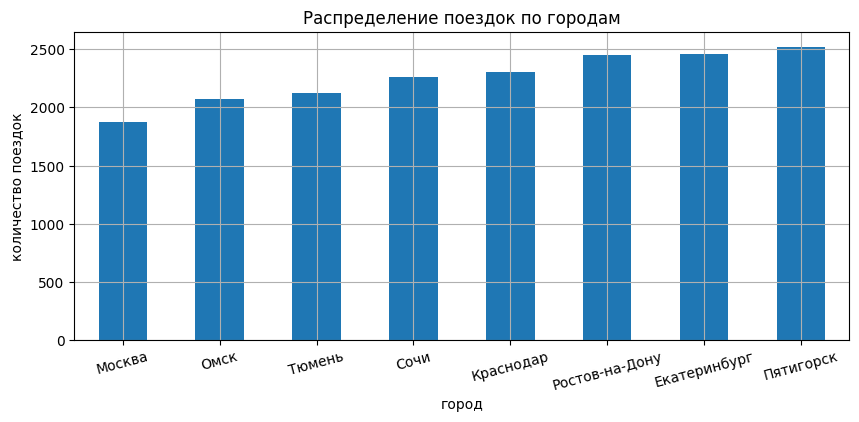

In [58]:
# строим столбчатую диаграмму
(data['city']
 .value_counts(ascending=True)
 .plot.bar(figsize=(10, 4), grid=True, rot=15)
)
plt.title('Распределение поездок по городам')
plt.xlabel('город')
plt.ylabel('количество поездок')
plt.show()

Распределение доли поездок по городам визуализируем с помощью круговой диаграммы.

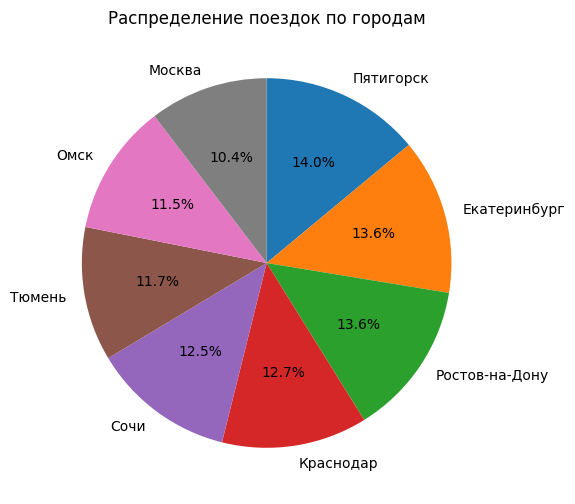

In [59]:
# строим и оформляем круговую диаграмму
(data['city']
 .value_counts()
 .plot.pie(figsize=(6, 6), startangle=90, counterclock=False, autopct='%.1f%%')
)
plt.title('Распределение поездок по городам')
plt.ylabel('')
plt.show()

Поездки распределены между городами практически так же, как и пользователи. Убедимся в этом, подсчитав среднее число поездок на одного пользователя для каждого города.

In [60]:
# формируем и оформляем сводную таблицу
(data
 .pivot_table(index=['city', 'user_id'], values='date', aggfunc='count')
 .reset_index()
 .pivot_table(index='city', values='date')
 .rename(columns={'date': 'avg_rides_per_user'})
 .round(1)
 .sort_values('avg_rides_per_user', ascending=False)
 .rename_axis('город')
 .rename(columns={'avg_rides_per_user': 'среднее число поездок на пользователя'})
)

,среднее число поездок на пользователя
город,
Ростов-на-Дону,12.4
Екатеринбург,12.1
Сочи,12.0
Краснодар,11.9
Тюмень,11.8
Пятигорск,11.5
Омск,11.3
Москва,11.2


Среднее число поездок на одного пользователя в зависимости от города меняется незначительно - от 11,1 в Москве до 12,3 в Ростове, т.е. в пределах ±5 % от среднего уровня 11,7.

### Разделение данных о пользователях с подпиской и без подписки

Выделим данные о пользователях с подпиской и без подписки в отдельные таблицы.

In [61]:
# данные о пользователях без подписки
data_free = data.query('subscription_type == "free"')
# данные о пользователях с подпиской
data_ultra = data.query('subscription_type == "ultra"')

In [62]:
print('Количество поездок пользователей без подписки:', len(data_free))
print('Количество поездок пользователей с подпиской:', len(data_ultra))

Количество поездок пользователей без подписки: 11568
Количество поездок пользователей с подпиской: 6500


Количество поездок пользователей с подпиской в 1,8 раза меньше, чем у пользователей без подписки. Тем не менее, обе выборки достаточно велики.

### Расстояние и продолжительность поездок пользователей с подпиской и без подписки

#### Расстояние поездок

Построим на одном графике гистограммы распределения поездок по расстоянию для пользователей с подпиской и без подписки, чтобы сравнить их.

Для выбора диапазона построения гистограмм и количества корзин нужно узнать диапазон изменения величины.

In [63]:
# характеристики распределения значений в столбце
column_stat(data, 'distance')

,count,min,mean,std,median,max
column,,,,,,
distance,18068,0.86,3070.66,1116.83,3133.61,7211.01


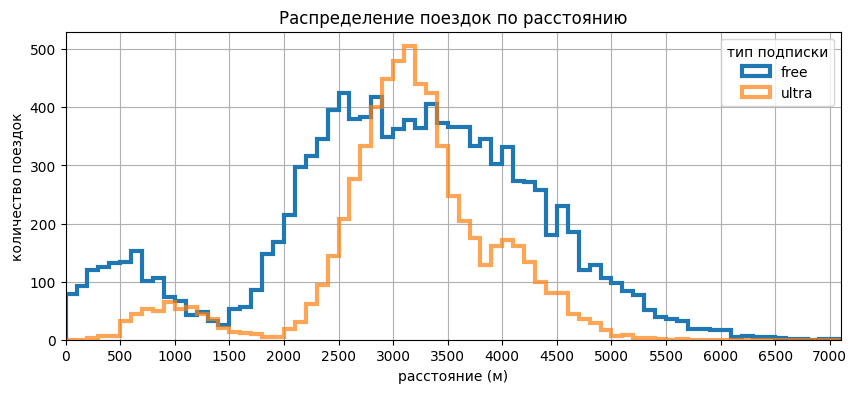

In [64]:
# строим и оформляем гистограмму
ax = data_free.plot.hist(
    y='distance', bins=71, range=(0, 7100), figsize=(10, 4),
    histtype='step', label='free', linewidth=3,
)
data_ultra.plot.hist(
    y='distance', bins=71, range=(0, 7100), ax=ax,
    histtype='step', label='ultra', linewidth=3, alpha=0.7,
)
plt.xlim((0, 7100))
plt.xticks(range(0, 7100, 500))
plt.title('Распределение поездок по расстоянию')
plt.xlabel('расстояние (м)')
plt.ylabel('количество поездок')
plt.legend(title='тип подписки')
plt.grid()
plt.show()

По построенным гистограммам видно:
- Для обеих категорий пользователей распределения расстояния поездок имеют максимум около 3 км, но для пользователей с подпиской распределение существенно более узкое, чем для пользователей без подписки. Вероятно, подписку обычно приобретают постоянные пользователи, совершающие регулярные поездки примерно на одно и то же расстояние.
- Распределения расстояния поездок для обеих категорий пользователей имеют побочный максимум в области коротких поездок, но его положение отличается в зависимости от категории:
   - Для пользователей без подписки максимум распределения расстояния коротких поездок находится около 500 м, причём значительна доля поездок на околонулевые расстояния. Вероятно, эти поездки совершают начинающие пользователи, которые пока только пробуют сервис и не освоили в достаточной мере использование приложения. 
   - Для пользователей с подпиской максимум коротких поездок находится около 1 км, и поездки на околонулевые расстояния отсутствуют. Это значит, что пользователи с подпиской уверенно пользуются сервисом для совершения поездок.

#### Продолжительность поездок

Построим на одном графике гистограммы распределения поездок по продолжительности для пользователей с подпиской и без подписки, чтобы сравнить их.

Для выбора диапазона построения гистограмм и количества корзин нужно узнать диапазон изменения величины.

In [65]:
# характеристики распределения значений в столбце
column_stat(data, 'duration')

,count,min,mean,std,median,max
column,,,,,,
duration,18068,0.5,17.81,6.09,17.68,40.82


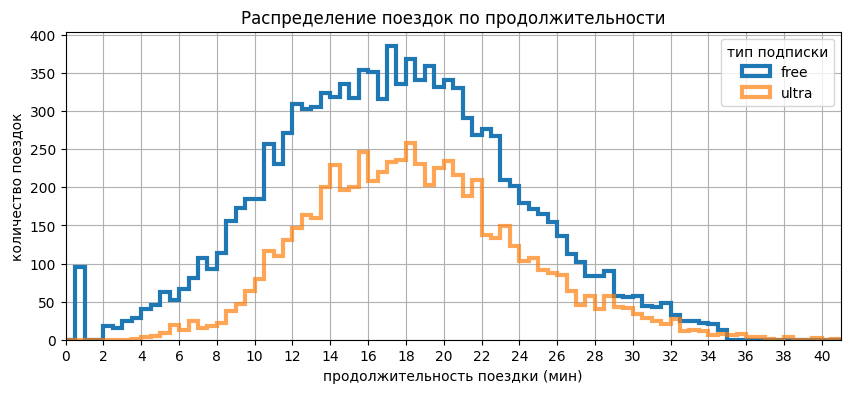

In [66]:
# строим и оформляем гистограмму
ax = data_free.plot.hist(
    y='duration', bins=82, range=(0, 41), figsize=(10, 4),
    histtype='step', label='free', linewidth=3,
)
data_ultra.plot.hist(
    y='duration', bins=82, range=(0, 41), ax=ax,
    histtype='step', label='ultra', linewidth=3, alpha=0.7,
)
plt.xlim((0, 41))
plt.xticks(range(0, 41, 2))
plt.title('Распределение поездок по продолжительности')
plt.xlabel('продолжительность поездки (мин)')
plt.ylabel('количество поездок')
plt.legend(title='тип подписки')
plt.grid()
plt.show()

По построенным гистограммам видно:
- Для обеих категорий пользователей распределение продолжительности поездок похоже на нормальное с центром около 18 минут. Величины разброса значений для обеих категорий пользователей отличаются не сильно.
- У пользователей без подписки чаще бывают поездки с очень малой продолжительностью, которые, вероятно, совершают начинающие пользователи. Среди них выделяются обнаруженные ранее аномальные поездки с продолжительностью 0,5 мин - случаи, когда пользователь отказался от совершения поездки. При этом у пользователей с подпиской отказов от поездки не наблюдается.
- Также у пользователей без подписки правый хвост распределения продолжительности поездок резко обрывается на значении 35 минут. Вероятно, это максимальная продолжительность одной поездки, которую позволяет сервис при отсутствии подписки.

Для сравнительного анализа распределения продолжительности поездок обеих категорий пользователей также построим диаграммы размаха.

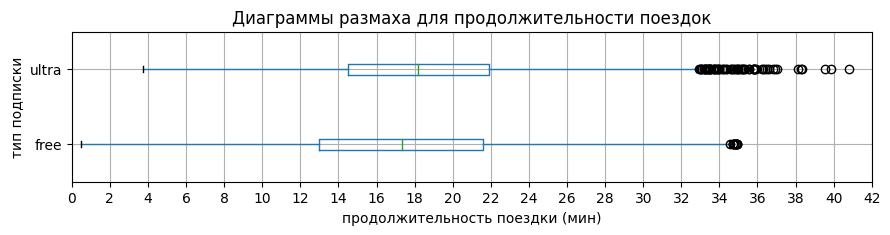

In [67]:
# строим диаграммы размаха
data.boxplot('duration', by='subscription_type', figsize=(10, 2), vert=False)
plt.xlim((0, 42))
plt.xticks(range(0, 43, 2))
plt.suptitle('')
plt.title('Диаграммы размаха для продолжительности поездок')
plt.xlabel('продолжительность поездки (мин)')
plt.ylabel('тип подписки')
plt.show()

По диаграммам размаха видно, что в имеющейся выборке медианное значение продолжительности поездки больше у пользователей с подпиской, а межквартильный размах больше у пользователей без подписки. Кроме того, распределение продолжительности поездок для пользователей с подпиской имеет более длинный хвост в области больших значений.

#### Совместное распределение расстояния и продолжительности поездок

Исследуем совместное распределение расстояния и продолжительности поездок для пользователей обеих категорий. Для этого построим диаграммы рассеяния для каждой категории.

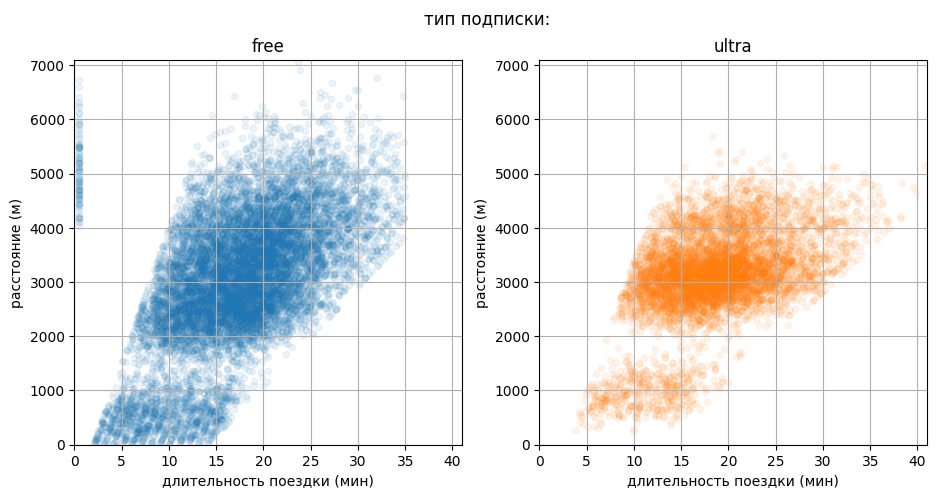

In [68]:
# строим диаграммы рассеяния
# в заданном диапазоне значений
fig, ax = plt.subplots(1, 2)
# пользователи без подписки
(data_free
 .plot.scatter(x='duration', y='distance', ax=ax[0], color='C0',
               xlim=(0, 41), ylim=(0, 7100),
               xlabel='длительность поездки (мин)', ylabel='расстояние (м)',
               alpha=0.08, grid=True, figsize=(11, 5)
              )
)
# пользователи с подпиской
(data_ultra
 .plot.scatter(x='duration', y='distance', ax=ax[1], color='C1',
               xlim=(0, 41), ylim=(0, 7100),
               xlabel='длительность поездки (мин)', ylabel='расстояние (м)',
               alpha=0.08, grid=True, figsize=(11, 5)
              )
)
fig.suptitle('тип подписки:')
ax[0].set_title('free')
ax[1].set_title('ultra')
plt.show()

Диаграммы рассеяния подтверждают наблюдения, сделанные ранее по гистограммам распределения расстояния и продолжительности поездок. 
- Поездки пользователей с подпиской сгруппированы более компактно на диаграмме, что говорит о большей однородности группы пользователей с подпиской в их сценариях использования сервиса.
- Для обеих категорий пользователей есть обособленный кластер коротких поездок. Вероятно, есть два типичных сценария использования сервиса - для поездок на короткие расстояния в пределах микрорайона и более длинные поездки по городу.
- Пользователи без подписки чаще совершают очень короткие и аномально медленные поездки. Видимо, это поездки начинающих пользователей, которые только пробуют сервис или испытывают трудности с его использованием.
- Поездки с продолжительностью 0,5 мин бывают только у пользователей без подписки. Вероятно, это случаи, когда пользователь отказался от совершения поездки. При этом у пользователей с подпиской отказов от поездки не наблюдается.
- Минимальная продолжительность поездок в сервисе составляет 2 минуты.
- Максимальная продолжительность поездок для пользователей без подписки в сервисе составляет 35 минут.

Исследуем среднюю скорость поездок. Для пользователей без подписки не учитываем аномальные поездки длительностью 0,5 мин.

In [69]:
# характеристики распределения значений в столбце
column_stat(data_free.query('duration > 1'), 'avg_speed')

,count,min,mean,std,median,max
column,,,,,,
avg_speed,11473,0.01,10.65,4.28,10.3,25.39


In [70]:
# характеристики распределения значений в столбце
column_stat(data_ultra, 'avg_speed')

,count,min,mean,std,median,max
column,,,,,,
avg_speed,6500,1.49,10.56,3.34,10.12,21.79


Средняя скорость поездки близка для пользователей обеих категорий, но её разброс больше для пользователей без подписки. Это также говорит в пользу того, что пользователи с подпиской в среднем более уверенно пользуются сервисом, поддерживая оптимальную скорость движения.

### Выводы

1. Данные о пользователях, поездках и подписках **объединены в одну таблицу**. Количество строк в объединённой таблице совпадает с количеством строк в таблице «Поездки», что подтверждает корректность объединения.
    - Поездки распределены между городами практически так же, как и пользователи. Среднее число поездок на одного пользователя в зависимости от города меняется не значительно - от 11,1 в Москве до 12,3 в Ростове, т.е. в пределах ±5% от среднего уровня 11,7.
<br/><br/>
2. Данные о пользователях с подпиской и без подписки **выделены в отдельные таблицы**. 
    - Количество поездок пользователей с подпиской (6500) в 1,8 раза меньше, чем у пользователей без подписки (11568). Тем не менее, обе выборки достаточно велики.
<br/><br/>
3. По гистограммам **распределения поездок по расстоянию** для пользователей с подпиской и без подписки установлено:
    - Для обеих категорий пользователей распределения расстояния поездок имеют максимум около 3 км, но для пользователей с подпиской распределение существенно более узкое, чем для пользователей без подписки. Вероятно, подписку обычно приобретают постоянные пользователи, совершающие регулярные поездки примерно на одно и то же расстояние.
    - Распределения расстояния поездок для обеих категорий пользователей имеют побочный максимум в области коротких поездок, но его положение отличается в зависимости от категории:
       - Для пользователей без подписки максимум распределения расстояния коротких поездок находится около 500 м, причём значительна доля поездок на околонулевые расстояния. Вероятно, эти поездки совершают начинающие пользователи, которые пока только пробуют сервис и не освоили в достаточной мере использование приложения. 
       - Для пользователей с подпиской максимум коротких поездок находится около 1 км, и поездки на околонулевые расстояния отсутствуют. Это значит, что пользователи с подпиской уверенно пользуются сервисом для совершения поездок.
<br/><br/>
4. По гистограммам **распределения поездок по продолжительности** для пользователей с подпиской и без подписки установлено:
    - Для обеих категорий пользователей распределение продолжительности поездок похоже на нормальное с центром около 18 минут. Величины разброса значений для обеих категорий пользователей отличаются не сильно.
    - У пользователей без подписки бывают поездки с продолжительностью 0,5 мин - случаи, когда пользователь отказался от совершения поездки. При этом у пользователей с подпиской отказов от поездки не наблюдается. Это указывает на то, что пользователи с подпиской пользуются сервисом более осознанно.
    - Также у пользователей без подписки правый хвост распределения продолжительности поездок резко обрывается на значении 35 минут. Вероятно, это максимальная продолжительность одной поездки, которую позволяет сервис при отсутствии подписки.
<br/><br/>
5. В результате исследования **совместного распределения расстояния и продолжительности поездок** для пользователей обеих категорий по диаграммам рассеяния подтверждаются наблюдения, сделанные ранее по гистограммам распределения расстояния и продолжительности поездок:
    - Поездки пользователей с подпиской сгруппированы более компактно, что говорит о большей однородности группы пользователей с подпиской в их сценариях использования сервиса.
    - Для обеих категорий пользователей есть обособленный кластер коротких поездок. Вероятно, есть два типичных сценария использования сервиса - для поездок на короткие расстояния в пределах микрорайона и более длинные поездки по городу.
    - Пользователи без подписки чаще совершают очень короткие и аномально медленные поездки. Видимо, это поездки начинающих пользователей, которые только пробуют сервис или испытывают трудности с его использованием.
    - Минимальная допустимая продолжительность поездок в сервисе составляет 2 минуты.
    - Максимальная допустимая продолжительность поездок для пользователей без подписки в сервисе составляет 35 минут.
<br/><br/>
6. **Средняя скорость поездок** оказалась близка для пользователей обеих категорий, но её разброс больше для пользователей без подписки. Это также говорит в пользу того, что пользователи с подпиской в среднем более уверенно пользуются сервисом, поддерживая оптимальную скорость движения.

## Подсчёт выручки

### Агрегированные данные о поездках

Для удобства последующего расчёта помесячной выручки добавим в общую таблицу с данными столбец `minutes`, значения в котором  - это продолжительность каждой поездки, округлённое до целого числа минут в большую сторону.

In [71]:
# округляем в большую сторону, приводим к типу int и
# добавляем столбец в таблицу
data['minutes'] = np.ceil(data['duration']).astype(int)

Создадим таблицу с агрегированными данными о поездках, в которой будут содержаться суммарное количество поездок (столбец `total_rides`), суммарное расстояние (столбец `total_distance`) и суммарная продолжительность (столбец `total_duration`) всех поездок каждого пользователя за каждый месяц.

Для последующего расчёта стоимости поездок каждого пользователя также добавим в таблицу столбец `total_minutes` с суммой округлённых вверх до минут продолжительностей поездок.

In [72]:
# формируем сводную таблицу с агрегированными данными 
stat = (
    data
    .groupby(['user_id', 'month'])
    .agg({
        'date': 'count',
        'distance': 'sum',
        'duration': 'sum',
        'minutes': 'sum',
    })
    .round(2)
    .reset_index()
    .rename(columns={
        'date': 'total_rides',
        'distance': 'total_distance',
        'duration': 'total_duration',
        'minutes': 'total_minutes',
    })
)

Проверим результат.

In [73]:
# выводим первые 10 строк
stat.head(10)

,user_id,month,total_rides,total_distance,total_duration,total_minutes
0,1,1,2,7027.51,41.42,42
1,1,4,1,754.16,6.23,7
2,1,8,2,6723.47,44.78,46
3,1,10,2,5809.91,31.58,32
4,1,11,3,7003.50,53.40,56
5,1,12,2,6751.63,27.20,28
6,2,3,3,10187.72,60.96,63
7,2,4,2,6164.38,39.05,40
8,2,6,1,3255.34,13.85,14
9,2,7,2,6780.72,46.17,48


In [74]:
# общая информация о таблице
stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         11331 non-null  int64  
 1   month           11331 non-null  int64  
 2   total_rides     11331 non-null  int64  
 3   total_distance  11331 non-null  float64
 4   total_duration  11331 non-null  float64
 5   total_minutes   11331 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 531.3 KB


### Подсчёт помесячной выручки

Для подсчёта помесячной выручки по таблице с агрегированными данными о поездках создадим функцию `month_revenue()`, которую применим к строкам этой таблицы.

In [75]:
def month_revenue(row):
    # получаем user_id пользователя
    user_id = row['user_id']
    # находим тип подписки пользователя
    subscription_type = users.loc[user_id, 'subscription_type']
    # находим параметры тарифа пользователя
    plan = subscriptions.loc[subscription_type]
    # считаем выручку от пользователя за месяц
    revenue = (plan['start_ride_price'] * row['total_rides'] 
               + plan['minute_price'] * row['total_minutes']
               + plan['subscription_fee']
              )
    return revenue

Добавим в таблицу с агрегированными данными о поездках столбец `revenue` с помесячной выручкой, которую принёс каждый пользователь.

In [76]:
# применяем функцию month_revenue() к строкам таблицы stat,
stat['revenue'] = stat.apply(month_revenue, axis=1).astype(int)

Проверим результат.

In [77]:
# выводим первые 10 строк
stat.head(10)

,user_id,month,total_rides,total_distance,total_duration,total_minutes,revenue
0,1,1,2,7027.51,41.42,42,451
1,1,4,1,754.16,6.23,7,241
2,1,8,2,6723.47,44.78,46,475
3,1,10,2,5809.91,31.58,32,391
4,1,11,3,7003.50,53.40,56,535
5,1,12,2,6751.63,27.20,28,367
6,2,3,3,10187.72,60.96,63,577
7,2,4,2,6164.38,39.05,40,439
8,2,6,1,3255.34,13.85,14,283
9,2,7,2,6780.72,46.17,48,487


In [78]:
# общая информация о таблице
stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         11331 non-null  int64  
 1   month           11331 non-null  int64  
 2   total_rides     11331 non-null  int64  
 3   total_distance  11331 non-null  float64
 4   total_duration  11331 non-null  float64
 5   total_minutes   11331 non-null  int64  
 6   revenue         11331 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 619.8 KB


### Вывод

Сформирована таблица с агрегированными данными о поездках каждого пользователя за каждый месяц, содержащая следующие сведения:
- суммарное количество поездок пользователя за месяц,
- суммарное расстояние поездок пользователя за месяц,
- суммарная продолжительность поездок пользователя за месяц,
- сумма округлённых вверх до целого числа минут продолжительностей поездок пользователя за месяц,
- суммарная выручка, которую принёс пользователь за месяц (помесячная выручка).

## Проверка гипотез

### Сравнение продолжительности поездок пользователей с подпиской и без подписки

Проверим гипотезу о том, тратят ли пользователи с подпиской больше времени на поездки.

Сформулируем **нулевую гипотезу** $H_0$: «Средняя по генеральной совокупности продолжительность поездок пользователей с подпиской равна средней по генеральной совокупности продолжительности поездок пользователей без подписки».

В качестве **альтернативной гипотезы** $H_1$ выберем правостороннюю: «Средняя по генеральной совокупности продолжительность поездок пользователей с подпиской **больше** средней по генеральной совокупности продолжительности поездок пользователей без подписки».

Для начала оценим размер выборок и характеристики распределения значений в них.

In [79]:
print('Количество поездок пользователей без подписки:', len(data_free))
print('Количество поездок пользователей с подпиской:', len(data_ultra))

Количество поездок пользователей без подписки: 11568
Количество поездок пользователей с подпиской: 6500


Характеристики распределения значений продолжительности поездок для пользователей без подписки:

In [80]:
# характеристики распределения значений в столбце
column_stat(data_free, 'duration')

,count,min,mean,std,median,max
column,,,,,,
duration,11568,0.5,17.39,6.33,17.33,34.95


Характеристики распределения значений продолжительности поездок для пользователей с подпиской:

In [81]:
# характеристики распределения значений в столбце
column_stat(data_ultra, 'duration')

,count,min,mean,std,median,max
column,,,,,,
duration,6500,3.76,18.54,5.57,18.18,40.82


Сравниваемые выборки отличаются по размеру. Стандартное отклонение у них тоже отличается, хотя и не сильно. Таким образом, обе выборки достаточно велики, чтобы и по отдельности достаточно точно оценить дисперсию каждой генеральной совокупности, а их объединение не сильно увеличит точность оценки дисперсии. А если дисперсии и правда разные, то такое объединение только исказит картину. Поэтому при проведении t-теста для проверки статистической гипотезы не будем использовать предположение о равенстве дисперсий генеральных совокупностей.

Рассчитаем среднюю продолжительность поездок пользователей с подпиской и без подписки.

In [82]:
print(f"Средняя продолжительность поездок пользователей с подпиской: "
      f"{data_ultra['duration'].mean():.2f} минут")
print(f"Средняя продолжительность поездок пользователей без подписки: "
      f"{data_free['duration'].mean():.2f} минут")

Средняя продолжительность поездок пользователей с подпиской: 18.54 минут
Средняя продолжительность поездок пользователей без подписки: 17.39 минут


Для имеющихся выборок средняя продолжительность поездок пользователей с подпиской больше средней продолжительности поездок пользователей без подписки. 

Чтобы сделать вывод о соотношении средних значений для соответствующих генеральных совокупностей, нужно проверить, с какой вероятностью можно получить данную или большую разницу в предположении, что верна нулевая гипотеза. Если эта вероятность (p-value) окажется меньше заданного уровня статистической значимости $\alpha$, тогда можно отвергнуть нулевую гипотезу в пользу альтернативной.

Для проверки гипотезы используем двухвыборочный t-тест для независимых выборок.

Уровень статистической значимости зададим равным $\alpha = 0.05$.

In [83]:
# задаём уровень статистической значимости
alpha = 0.05

# проводим t-тест для двух независимых выборок,
# не считая равными дисперсии соответствующих ген. совокупностей,
# альтернативная гипотеза - правосторонняя («больше»)
result = st.ttest_ind(data_ultra['duration'], data_free['duration'], 
                      equal_var=False, alternative='greater')

print(f'Статистика разности (t-statistic): {result.statistic:.2f}')
print(f'P-value: {result.pvalue:.4g}')
print()
print('Уровень статистической значимости:', alpha)

# проверяем p-value
if result.pvalue < alpha:
    print(f'P-value < {alpha}. Отвергаем нулевую гипотезу.')
else:
    print(f'P-value ≥ {alpha}. Нельзя отвергнуть нулевую гипотезу.')

Статистика разности (t-statistic): 12.68
P-value: 5.676e-37

Уровень статистической значимости: 0.05
P-value < 0.05. Отвергаем нулевую гипотезу.


Проверка показала, что можно отвергнуть нулевую гипотезу о равенстве истинных средних значений продолжительности поездок пользователей с подпиской и без подписки в пользу альтернативной правосторонней гипотезы. 

Таким образом, можно утверждать, что для генеральных совокупностей **средняя продолжительность поездок пользователей с подпиской больше средней продолжительности поездок пользователей без подписки**.

### Расстояние одной поездки пользователей с подпиской

Проверим гипотезу о том, что **среднее** расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального с точки зрения износа самоката значения 3130 м.

Сформулируем **нулевую гипотезу** $H_0$: «Среднее по генеральной совокупности расстояние одной поездки пользователей с подпиской равно 3130 м».

В качестве **альтернативной гипотезы** $H_1$ выберем правостороннюю: «Среднее по генеральной совокупности расстояние одной поездки пользователей с подпиской **больше** 3130 м».

Если окажется, что нулевую гипотезу отвергнуть нельзя, это будет означать, что истинное среднее расстояние одной поездки пользователей с подпиской меньше или равно 3130 м, потому что в качестве альтернативной гипотезы выбрана правосторонняя.

Рассчитаем среднее по выборке расстояние одной поездки пользователей с подпиской.

In [84]:
print(f"Среднее расстояние одной поездки пользователей с подпиской: "
      f"{data_ultra['distance'].mean():.2f} м")

Среднее расстояние одной поездки пользователей с подпиской: 3115.45 м


Для имеющейся выборки среднее расстояние одной поездки пользователей с подпиской меньше 3130 м.

Для проверки гипотезы о среднем значении генеральной совокупности используем одновыборочный t-тест на равенство истинного среднего заданному числу.

Уровень статистической значимости зададим равным $\alpha = 0.05$.

In [85]:
# задаём предполагаемое среднее ген. совокупности
L = 3130

# задаём уровень статистической значимости
alpha = 0.05

# проводим t-тест для одной выборки,
# альтернативная гипотеза - правосторонняя («больше»)
result = st.ttest_1samp(data_ultra['distance'], L, alternative='greater')

print(f'Статистика разности (t-statistic): {result.statistic:.2f}')
print(f'P-value: {result.pvalue:0.4g}')
print()
print('Уровень статистической значимости:', alpha)

# проверяем p-value
if result.pvalue < alpha:
    print(f'P-value < {alpha}. Отвергаем нулевую гипотезу.')
else:
    print(f'P-value ≥ {alpha}. Нельзя отвергнуть нулевую гипотезу.')

Статистика разности (t-statistic): -1.40
P-value: 0.9195

Уровень статистической значимости: 0.05
P-value ≥ 0.05. Нельзя отвергнуть нулевую гипотезу.


Проверка показала, что нельзя отвергнуть нулевую гипотезу о том, что истинное среднее расстояние одной поездки пользователей с подпиской равно 3130 м, в пользу альтернативной гипотезы о том, что это расстояние больше 3130 м.

Таким образом, можно утверждать, что для генеральной совокупности **среднее расстояние одной поездки пользователей с подпиской не превышает 3130 м**.

Тем не менее, **нельзя утверждать**, что расстояние *всех* или по крайней мере *большинства* поездок не превышает 3130 м. 

Рассмотрим характеристики распределения значений расстояния поездок для пользователей с подпиской в выборке:

In [86]:
# характеристики распределения значений в столбце
column_stat(data_ultra, 'distance')

,count,min,mean,std,median,max
column,,,,,,
distance,6500,244.21,3115.45,836.9,3148.64,5699.77


Медиана распределения составляет ≈3149 м, т.е. половина поездок совершаются на расстояние, превышающее это значение. Найдём, какая доля поездок длиннее 3130 м.

In [87]:
# находим долю поездок длиннее 3130 м
print('Доля поездок длиннее 3130 м:',(data_ultra['distance'] > 3130).mean().round(4))

Доля поездок длиннее 3130 м: 0.5154


Для 51,5 % поезок пользователей с подпиской в выборке расстояние превышает 3130 м. Чтобы оценить верхнюю границу распределения расстояния, найдём квантили распределения. 

In [88]:
# находим квантили распределения
data_ultra['distance'].quantile([0.9, 0.95, 0.99]).round(2)

0.90    4133.19
0.95    4382.29
0.99    4804.46
Name: distance, dtype: float64

Получается, пользователи с подпиской в выборке 10 % поездок совершают на расстояние более 4133 м, 5 % на расстояние более 4382 м и 1 % на расстояние более 4804 м.

Медиану генеральной совокупности можно приближённо оценить выборочной медианой. Для симметричных распределений медиана совпадает со средним. В общем случае медиана, как правило, отстоит от среднего не более чем на величину стандартного отклонения.  В случае рассматриваемого распределения расстояния поездок медиана немного больше среднего из-за значительной доли коротких поездок. Тем не менее, для приближённой оценки можно считать распределение примерно симметричным. Тогда медиана генеральной совокупности тоже будет не сильно отличаться от истинного среднего.

Поскольку нулевую гипотезу о равенстве истинного среднего расстояния поездки значению 3130 м отвергнуть нельзя, то при таком значении истинного среднего расстояние значительной доли (примерно половины) поездок будет превышать 3130 м.

Поэтому **нельзя утверждать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**. Это утверждение будет верно только лишь для примерно **половины всех поездок**.

### Сравнение помесячной выручки от пользователей с подпиской и без подписки

#### Подготовка данных

Для выделения из таблицы с агрегированными данными о поездках каждого пользователя за каждый месяц данных по пользователям с подпиской и без подписки добавим в таблицу столбец `subscription_type` с типом подписки пользователя.

In [89]:
# добавляем столбец 'subscription_type' в таблицу,
# применяя к столбцу 'user_id' функцию, 
# которая возвращает тип подписки пользователя по его user_id
stat['subscription_type'] = stat['user_id'].apply(lambda x: users.loc[x, 'subscription_type'])

Создадим итоговую таблицу, в которой для каждого месяца будут представлены количество пользователей с подпиской и без подписки и средняя помесячная выручка от них.

In [90]:
# формируем итоговую таблицу
results = (
    stat
    .pivot_table(
        index='month', 
        columns='subscription_type', 
        values='revenue',
        aggfunc=['count', 'mean'],
    )
    .round(2)
    .reset_index()
)
# переименовываем столбцы
results.columns = ['month', 'users_free', 'users_ultra', 'revenue_free',  'revenue_ultra']

Добавим также в таблицу столбец `ultra_share`, в котором будет доля пользователей с подпиской, и столбец `revenue_diff`, в котором будет разность значений помесячной выручки от пользователей с подпиской и без подписки.

In [91]:
# добавляем столбец в таблицу
results['ultra_share'] = (results['users_ultra'] 
                          .div(results['users_ultra'] + results['users_free'])
                          .round(4)
                         )
# добавляем столбец в таблицу
results['revenue_diff'] = results['revenue_ultra'] - results['revenue_free']

Выведем получившуюся таблицу.

In [92]:
# выводим таблицу
results

,month,users_free,users_ultra,revenue_free,revenue_ultra,ultra_share,revenue_diff
0,1,600,390,323.08,369.51,0.3939,46.43
1,2,529,354,313.53,351.90,0.4009,38.37
2,3,556,396,336.72,360.12,0.4160,23.40
3,4,553,374,335.62,367.16,0.4035,31.54
4,5,573,405,328.15,368.48,0.4141,40.33
5,6,589,398,326.22,361.39,0.4032,35.17
6,7,562,390,329.25,367.86,0.4097,38.61
7,8,565,384,331.18,360.77,0.4046,29.59
8,9,577,355,335.70,364.33,0.3809,28.63
9,10,549,372,330.47,360.03,0.4039,29.56


Визуализируем данные в таблице, построив графики.

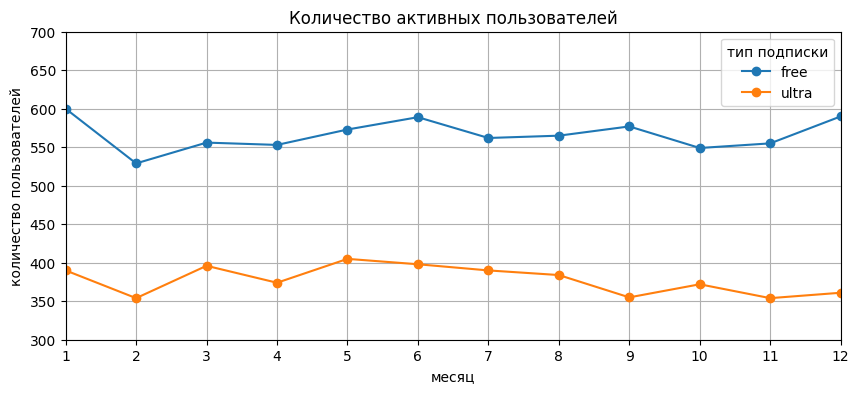

In [93]:
# строим графики
(results
 .plot(x='month', y=['users_free', 'users_ultra'], label=['free', 'ultra'],
       style='o-', figsize=(10, 4), grid=True,
      )
)
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.ylim(300, 700)
plt.title('Количество активных пользователей')
plt.xlabel('месяц')
plt.ylabel('количество пользователей')
plt.legend(title='тип подписки')
plt.show()

Количество активных пользователей варьируется в течение года незначительно, примерно в пределах ±10 %.

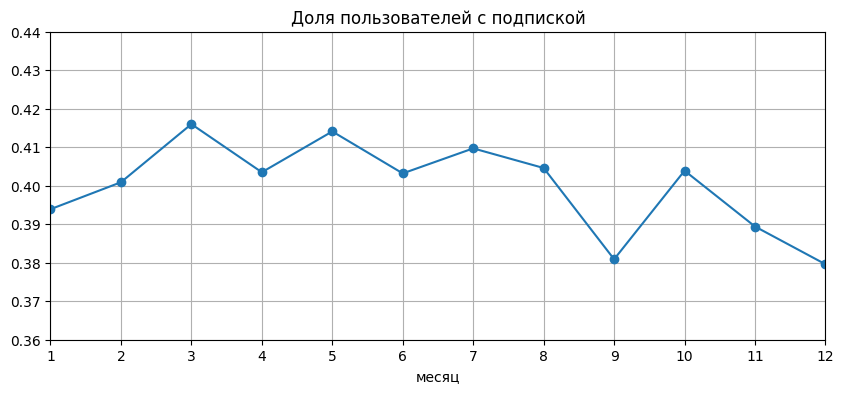

In [94]:
# строим график
(results
 .plot(x='month', y='ultra_share',
       style='o-', figsize=(10, 4), grid=True, legend=False,
      )
)
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.ylim(0.36, 0.44)
plt.title('Доля пользователей с подпиской')
plt.xlabel('месяц')
plt.ylabel('')
plt.show()

Доля пользователей с подпиской тоже относительно стабильна и меняется в течение года от 38 % до 42 %.

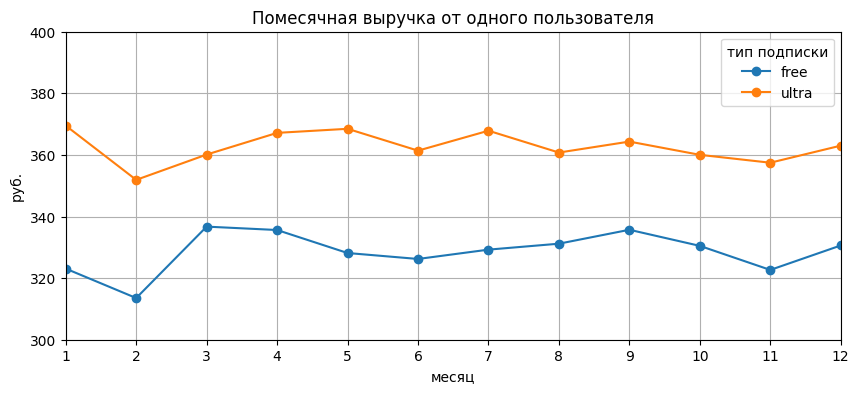

In [95]:
# строим графики
(results
 .plot(x='month', y=['revenue_free', 'revenue_ultra'], label=['free', 'ultra'],
       style='o-', figsize=(10, 4), grid=True,
      )
)
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.ylim(300, 400)
plt.title('Помесячная выручка от одного пользователя')
plt.xlabel('месяц')
plt.ylabel('руб.')
plt.legend(title='тип подписки')
plt.show()

По графику видно, что в рассматриваемой выборке помесячная выручка от одного пользователя с подпиской стабильно превышает выручку от одного пользователя без подписки.

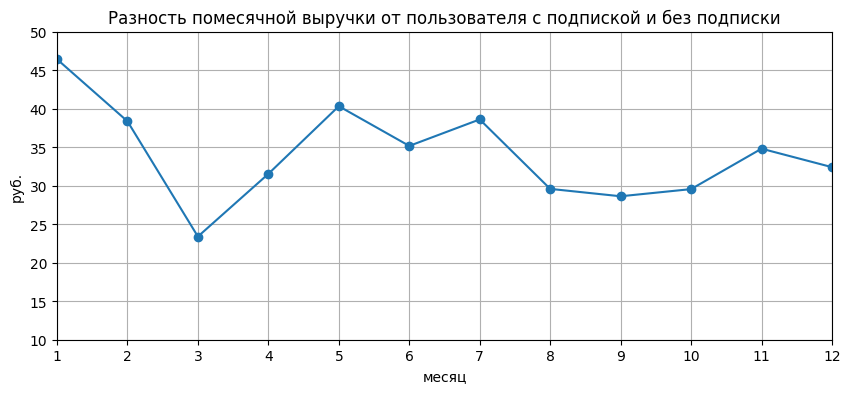

In [96]:
# строим график
(results
 .plot(x='month', y='revenue_diff',
       style='o-', figsize=(10, 4), grid=True, legend=False,
      )
)
plt.xlim(1, 12)
plt.xticks(range(1, 13))
plt.ylim(10, 50)
plt.title('Разность помесячной выручки от пользователя с подпиской и без подписки')
plt.xlabel('месяц')
plt.ylabel('руб.')
plt.show()

Разность помесячной выручки от пользователя с подпиской и без подписки в зависимости от месяца меняется в диапазоне от 21 до 45 рублей.

#### Проверка гипотезы

Проверим гипотезу о том, будет ли **средняя** помесячная выручка от пользователя с подпиской по месяцам выше, чем помесячная выручка от пользователя без подписки. Для этого нужно сравнить среднюю помесячную выручку пользователей обеих категорий за каждый месяц года.

Сформулируем **нулевую гипотезу** $H_0$: «Средняя по генеральной совокупности помесячная выручка от пользователя с подпиской равна средней по генеральной совокупности помесячной выручке от пользователя без подписки».

В качестве **альтернативной гипотезы** $H_1$ выберем правостороннюю: «Средняя по генеральной совокупности помесячная выручка от пользователя с подпиской **больше** средней по генеральной совокупности помесячной выручки от пользователя без подписки».

Для имеющихся выборок средняя помесячная выручка от пользователя с подпиской больше средней помесячной выручки от пользователя без подписки. 

Чтобы сделать вывод о соотношении средних значений для соответствующих генеральных совокупностей, нужно проверить, с какой вероятностью можно получить данную или большую разницу в предположении, что верна нулевая гипотеза. Если эта вероятность (p-value) окажется меньше заданного уровня статистической значимости $\alpha$, тогда можно отвергнуть нулевую гипотезу в пользу альтернативной.

Для проверки гипотезы используем двухвыборочный t-тест для независимых выборок.

Уровень статистической значимости зададим равным $\alpha = 0.05$.

Сравниваемые выборки не очень большие и не сильно отличаются по размеру между собой. Стандартное отклонение у них тоже не должно сильно отличаться. Поэтому при проведении t-теста для проверки статистической гипотезы используем предположение о равенстве дисперсий генеральных совокупностей, чтобы получить более точную оценку стандартного отклонения выборочного распределения.

Для проведения t-теста для выборок пользователей за конкретный месяц с номером `month` создадим функцию `ttest_monthly(month)`, которая возвращает результат теста - p-value.

In [97]:
def ttest_monthly(month):
    """
    Проводит t-тест для двух независимых выборок со значениями месячной выручки 
    от пользователей с подпиской и без подписки для заданного в аргументе номера месяца 
    и возвращает p-value.
    """
    # ряд значений месячной выручки от пользователей без подписки
    revenue_free = stat.query('month == @month and subscription_type == "free"')['revenue']
    # ряд значений месячной выручки от пользователей с подпиской
    revenue_ultra = stat.query('month == @month and subscription_type == "ultra"')['revenue']
    
    # проводим t-тест для двух независимых выборок,
    # не считая равными дисперсии соответствующих ген. совокупностей,
    # альтернативная гипотеза - правосторонняя («больше»)
    result = st.ttest_ind(revenue_ultra, revenue_free, 
                          equal_var=True, alternative='greater')
    return result.pvalue    

Для формирования вывода о возможности отвергнуть нулевую гипотезу для заданного уровня статистической значимости `alpha` по полученному в результате t-теста значению p-value (`pvalue`)  создадим функцию `hypothesis_test(pvalue, alpha)`, которая сравнивает аргументы и возвращает вывод в текстовой форме.

In [98]:
def hypothesis_test(pvalue, alpha):
    """
    По заданным аргументам - значению p-value и уровню статистической значимости 
    возвращает результат проверки гипотезы: отвергнуть нулевую гипотезу или нет.
    """
    if pvalue < alpha:
        return 'Отвергаем нулевую гипотезу.'
    else:
        return 'Нельзя отвергнуть нулевую гипотезу.'

Проводим t-тест для каждого месяца года.

In [99]:
# применяем функцию ttest_monthly() к столбцу 'month'
results['pvalue'] = results['month'].apply(ttest_monthly)

Формируем вывод о возможности для заданного уровня статистической значимости отвергнуть нулевую гипотезу в пользу альтернативной.

In [100]:
# задаём уровень статистической значимости
alpha = 0.05
# проверяем p-value для каждого месяца и 
# записываем результат в новый столбец
results['ttest_result'] = results['pvalue'].apply(hypothesis_test, args=(alpha,))

Выводим итоговую таблицу с результатами проверки гипотезы для каждого месяца.

In [101]:
# выводим таблицу
# делаем столбец 'month' индексом
results.set_index('month')

,users_free,users_ultra,revenue_free,revenue_ultra,ultra_share,revenue_diff,pvalue,ttest_result
month,,,,,,,,
1,600,390,323.08,369.51,0.3939,46.43,0.000003,Отвергаем нулевую гипотезу.
2,529,354,313.53,351.90,0.4009,38.37,0.000121,Отвергаем нулевую гипотезу.
3,556,396,336.72,360.12,0.4160,23.40,0.010735,Отвергаем нулевую гипотезу.
4,553,374,335.62,367.16,0.4035,31.54,0.001067,Отвергаем нулевую гипотезу.
5,573,405,328.15,368.48,0.4141,40.33,0.000033,Отвергаем нулевую гипотезу.
6,589,398,326.22,361.39,0.4032,35.17,0.000177,Отвергаем нулевую гипотезу.
7,562,390,329.25,367.86,0.4097,38.61,0.000084,Отвергаем нулевую гипотезу.
8,565,384,331.18,360.77,0.4046,29.59,0.002172,Отвергаем нулевую гипотезу.
9,577,355,335.70,364.33,0.3809,28.63,0.002163,Отвергаем нулевую гипотезу.


Проверка показала, что для всех месяцев можно отвергнуть нулевую гипотезу о равенстве истинных средних значений помесячной выручки от пользователя с подпиской и без подписки в пользу альтернативной правосторонней гипотезы. 

Таким образом, можно утверждать, что для генеральных совокупностей **средняя помесячная выручка от пользователя с подпиской больше средней помесячной выручки от пользователя без подписки**.

**Примечание**: В марте (3-й месяц) p-value оказалось больше 0.01, поэтому при выборе уровня статистической значимости 0.01 отвергнуть нулевую гипотезу в пользу альтернативной будет нельзя. Поэтому значимость итогового вывода по результатам проверки гипотезы за этот месяц меньше, чем для других месяцев года.

### Сравнение количества обращений в техподдержку до и после обновления

Рассмотрим ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Предполагается, что благодаря этому количество обращений в техподдержку значимо снизилось. 

Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. 

Для проверки этой гипотезы нужно использовать **односторонний двухвыборочный t-тест для зависимых (парных) выборок**. Нулевая гипотеза $H_0$: количество обращений в техподдержку до обновления и после него одинаково. Альтернативная гипотеза $H_1$: количество обращений в техподдержку после обновления стало меньше, чем было до него.

Для проведения указанного t-теста для зависимых выборок применяется метод `scipy.stats.ttest_rel()`:

```python
result = st.ttest_rel(support_after, support_before, alternative='less')
```

Затем надо сравнить получившееся значение p-value `result.pvalue` с заданным заранее уровнем статистической значимости. Если p-value окажется меньше, то можно отвергнуть нулевую гипотезу в пользу альтернативной.

### Выводы

В результате **проверки статистических гипотез** установлено:

1. Средняя продолжительность поездок пользователей с подпиской значимо больше средней продолжительности поездок пользователей без подписки.

2. Среднее расстояние одной поездки пользователей с подпиской не превышает 3130 м. Тем не менее, нельзя утверждать, что расстояние *всех* или по крайней мере *большинства* поездок не превышает 3130 м. Это утверждение будет верно только лишь для примерно половины всех поездок.

3. При уровне статистической значимости 0.05 для всех месяцев года средняя помесячная выручка от пользователя с подпиской значимо больше средней помесячной выручки от пользователя без подписки. Однако при выборе уровня статистической значимости 0.01 для марта уже нельзя отвергнуть нулевую гипотезу о равенстве помесячной выручки для пользователей обеих категорий в пользу альтернативной гипотезы о том, что от пользователей с подпиской помесячная выручка больше. Поэтому значимость вывода по результатам проверки гипотезы за этот месяц меньше, чем для других месяцев года.

4. Для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, с которыми взаимодействует мобильное приложение, нужно использовать односторонний двухвыборочный t-тест для зависимых (парных) выборок с альтернативной гипотезой, что количество обращений в техподдержку после обновления стало меньше.

## Распределения

### Акция с раздачей промокодов на один бесплатный месяц подписки

В рамках акции как минимум 100 существующих клиентов должны продлить подписку по завершении бесплатного периода. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 

Выясним, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %.

По условиям задачи, вероятность, что пользователь по завершении бесплатного периода продлит подписку, составляет $p = 0.1$. Вероятность того, что $k$ пользователей продлит подписку из $n$, получивших промокоды, описывается биномиальным распределением $Binom(n, p)$ с параметрами $n$ и $p$:
$$P(k) = С_n ^k p^k (1-p)^{n-k}.$$
Заданная вероятность не выполнить план $P_{fail} = 0.05$ означает, что вероятность того, что подписку продлят меньше чем $m = 100$ пользователей, должна быть равна этой величине:
$$P(k < m) = P_{fail}$$
Биномиальное распределение - дискретное, поэтому $P(k < m) = P(k \le m-1) = CDF(m-1)$, где $CDF$ - кумулятивная функция биномиального распределения $Binom(n, p)$.

Таким образом, нужно найти такое $n$, что $CDF(m-1) = P_{fail}$  для биномиального распределения $Binom(n, p)$, где $m = 100$, $p = 0,1$, $P_{fail} = 0.05$.

In [102]:
# вероятность, что пользователь продлит подписку
p = 0.1
# минимальное число пользователей, которые должны продлить подписку
m = 100
# вероятность не выполнить план акции
prob_fail = 0.05

Для получения приближённой оценки неизвестной величины $n$ попробуем использовать аппроксимацию биномиального распределения нормальным. Для этого сначала нужно проверить условия применимости аппроксимации:
$$\mu - 3\sigma \ge 0 \text{ и } \mu + 3\sigma \le n,$$
где $\mu = n p$, $\sigma = \sqrt{n p (1-p)}$.
Из условия задачи очевидно, что $n$ должно быть значительно больше $m = 100$, чтобы обеспечить малую вероятность $P(k < m)$.

Подставляя в условие $\mu - 3\sigma \ge 0$ значение $p$, получим неравенство $0.1\sqrt{n}(\sqrt{n} - 9) \ge 0$, которое очевидно выполняется, т.к. $\sqrt{n} > \sqrt{m} = 10$.

Аналогично, условие $\mu + 3\sigma \le n$ сводится к неравенству $\sqrt{n} \ge 1$, которое очевидно выполняется.

Таким образом, в данной задаче можно использовать нормальное распределение для аппроксимации биномиального.

Величина $CDF(m-1)$ для биномиального распределения $Binom(n, p)$ аппроксимируется величиной $CDF_N(m-0.5)$ для нормального распределения $N(\mu, \sigma^2)$. Тогда условие задачи можно сформулировать в виде $CDF_N(m-0.5) = P_{fail}$.

Величина $\frac{(m-0.5) - \mu}{\sigma}$  будет иметь стандартное нормальное распределение $N(0, 1)$. Тогда условие $CDF_N(m-0.5) = P_{fail}$ эквивалентно соотношению 
$$\frac{(m-0.5) - \mu}{\sigma} = PPF(P_{fail}),$$
где $PPF$ - функция, обратная $CDF$.

Введём обозначение $y = PPF(P_{fail})$. Подставляя в полученное соотношение выражения для $\mu$ и $\sigma$, получим квадратное уравнение относительно $\sqrt{n}$:
$$pn + y\sqrt{np(1-p)} - (m - 0.5) = 0$$

Положительный корень этого уравнения находится по формуле
$$x = \sqrt{n} = \frac{1}{2p}(-y\sqrt{p(1-p)}+\sqrt{y^2p(1-p)+4p(m-0.5)})$$

Соответственно, приближённую оценку $n$ получим, округляя до целого значение $x^2$.

In [103]:
# PPF для стандартного нормального распределения
y = st.norm.ppf(prob_fail)
# приближённая оценка n
n_est = int(round(((-y * sqrt(p*(1-p)) + sqrt(y**2 * p*(1-p) + 4*p*(m-0.5))) / (2*p))**2))
print('Приближённая оценка минимального количества промокодов:', n_est)

# создаём нормальное распределение с 
# заданными мат. ожиданием и ст. отклонением
mu = n_est * p
sigma = sqrt(n_est * p * (1 - p))
norm_distr = st.norm(mu, sigma)
# проверяем выполнение условия задачи
print(f'Вероятность не выполнить план акции: {norm_distr.cdf(m - 0.5):.4f}')

Приближённая оценка минимального количества промокодов: 1163
Вероятность не выполнить план акции: 0.0503


Подберём наименьшее близкое к полученной оценке значение $n$, чтобы для исходного биномиального распределения вероятность не выполнить план акции была близка к 5 % с допускаемой погрешностью ± 0,1 %.

In [104]:
# погрешность вероятности не выполнить план акции
prob_diff = 0.001

# находим вероятности не выполнить план для диапазона n = 1163 ± 10
n_range = range(n_est - 10, n_est + 10)
prob_test = []
for n_test in n_range:
    test_distr = st.binom(n_test, p)
    prob = test_distr.cdf(m - 1)
    prob_test.append(prob)

# выводим результаты расчёта вероятности
s = pd.Series(
    data=prob_test, 
    index=n_range, 
    name='вероятность'
).rename_axis('n')
display(s.to_frame())

# находим минимальное n
n = s.sub(prob_fail + prob_diff).abs().idxmin()
print('Минимальное количество промокодов, которое нужно разослать:', n)

,вероятность
n,
1153,0.058087
1154,0.056988
1155,0.055905
1156,0.054840
1157,0.053792
1158,0.052760
1159,0.051744
1160,0.050744
1161,0.049761


Минимальное количество промокодов, которое нужно разослать: 1160


Проверим вероятность не выполнить план акции, если будет разослано 1160 промокодов.

In [105]:
# задаём биномиальное распределение с параметрами n и p
distr = st.binom(n, p)
print('Если разослать {} промокодов, то вероятность не выполнить план акции составит {:.4f}'
      .format(n, distr.cdf(m - 1))
     )

Если разослать 1160 промокодов, то вероятность не выполнить план акции составит 0.0507


Действительно, при рассылке 1160 промокодов вероятность не выполнить план акции составляет примерно 5 %.

Построим график биномиального распределения $Binom(n, p)$ с параметрами $n = 1160$ и $p = 0.1$, которое описывает вероятность того, что подписку продлят некоторое количество пользователей, получивших промокоды.

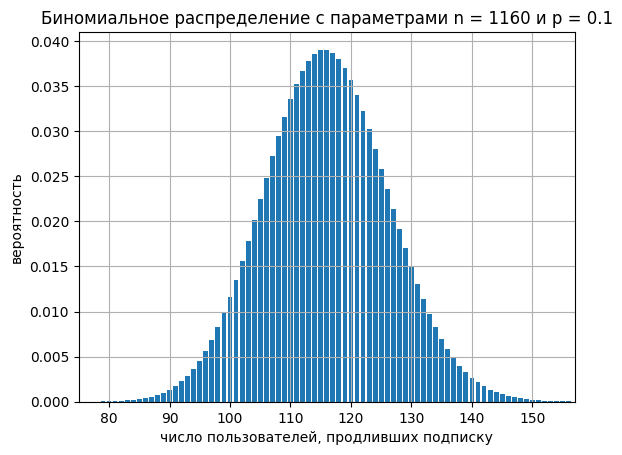

In [106]:
# определяем границы диапазона построения графика
left = round(mu - 4 * sigma)
right = round(mu + 4 * sigma)
# задаём диапазон значений аргумента
x = range(int(left), int(right)+1)
# строим и оформляем график
plt.bar(x, distr.pmf(x))
plt.xlim(left, right)
plt.title('Биномиальное распределение с параметрами n = 1160 и p = 0.1')
plt.xlabel('число пользователей, продливших подписку')
plt.ylabel('вероятность')
plt.grid()

Также построим график кумулятивной функции для этого биномиального распределения, которая описывает вероятность того, что подписку продлят не более некоторого количество пользователей, получивших промокоды.

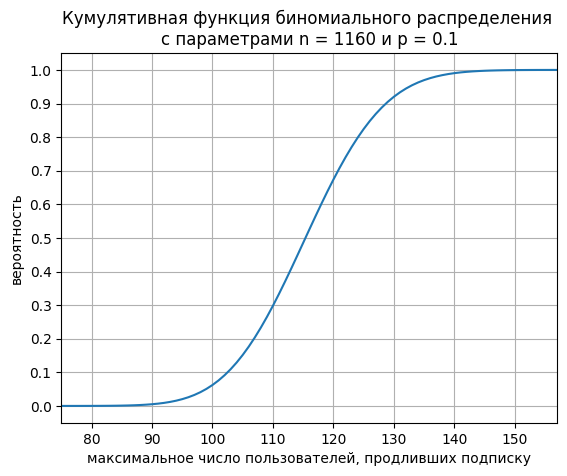

In [107]:
# строим и оформляем график
plt.plot(x, distr.cdf(x))
plt.xlim(left, right)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Кумулятивная функция биномиального распределения \nс параметрами n = 1160 и p = 0.1')
plt.xlabel('максимальное число пользователей, продливших подписку')
plt.ylabel('вероятность')
plt.grid()

**Вывод:**

Минимальное количество промокодов, которое нужно разослать, чтобы получить примерно равную 5 % вероятность не выполнить план  акции, в рамках которой как минимум 100 существующих клиентов должны продлить подписку по завершении бесплатного периода, составляет **1160**.

### Рассылка push-уведомлений в мобильном приложении

Нужно оценить вероятность того, что при рассылке 1 млн push-уведомлений в мобильном приложении уведомление откроют не более 399,5 тыс. пользователей. Известно, что уведомление открывают около 40 % получивших его пользователей.

In [108]:
# вероятность, что пользователь откроет уведомление
p = 0.4
# количество разосланных уведомлений
n = 1000000
# максимальное количество пользователей, которые должны открыть уведомление
m = 399500

Эта ситуация тоже описывается биномиальным распределением. Но поскольку количество испытаний, равное количеству разосланных уведомлений, очень велико, лучше воспользоваться аппроксимацией биномиального распределения нормальным.

Условия применимости аппроксимации:
$$\mu - 3\sigma \ge 0 \text{ и } \mu + 3\sigma \le n,$$
где $\mu = n p$, $\sigma = \sqrt{n p (1-p)}$ - параметры аппроксимирующего нормального распределения.

Эти условия выполняются:

In [109]:
# параметры нормального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

print('Мат. ожидание:', mu)
print(f'Стандартное отклоненение: {sigma:.3f}')
print('\nПроверяем условия применимости аппроксимации:')
print(f'{mu - 3 * sigma:.2f} ≥ 0: {mu - 3 * sigma >= 0}')
print(f'{mu + 3 * sigma:.2f} ≤ {n}: {mu - 3 * sigma <= n}')

Мат. ожидание: 400000.0
Стандартное отклоненение: 489.898

Проверяем условия применимости аппроксимации:
398530.31 ≥ 0: True
401469.69 ≤ 1000000: True


Видно, что плотность вероятности аппроксимирующего нормального распределения будет значимо отличаться от нуля только в узком диапазоне вблизи центра вследствие малого стандартного отклонения.

Построим графики функции плотности вероятности и кумулятивной функции вероятности для  нормального распределения $N(\mu, \sigma^2)$ с параметрами $\mu = n p$ и $\sigma = \sqrt{n p (1-p)}$, аппроксимирующего биномиальное распределение $Binom(n, p)$ с параметрами $n = 1000000$ и $p = 0.4$.

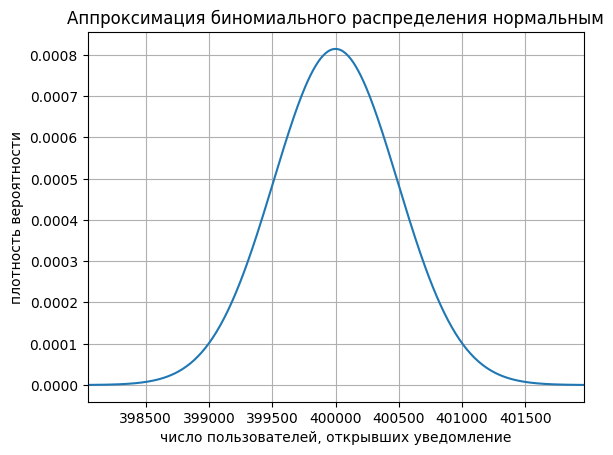

In [110]:
# создаём нормальное распределение с 
# заданными мат. ожиданием и ст. отклонением
distr = st.norm(mu, sigma)
# определяем границы диапазона построения графика
left = floor(mu - 4 * sigma)
right = ceil(mu + 4 * sigma)
# задаём диапазон и шаг значений аргумента
x = range(int(left), int(right)+1, 10)
# строим и оформляем график функции плотности вероятности
plt.plot(x, distr.pdf(x))
plt.xlim(left, right)
plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('число пользователей, открывших уведомление')
plt.ylabel('плотность вероятности')
plt.grid()


Вероятность того, что количество пользователей $n$, открывших уведомление, составит от $N_1$ до $N_2$, будет равна площади под графиком функции плотности вероятности $PDF(x)$ над отрезком $[N_1 - 0.5, N_2 + 0.5]$:
$$P(n \in [N_1, N_2]) = \int\limits_{N_1 - 0.5}^{N_2 + 0.5}{PDF(x) dx}.$$

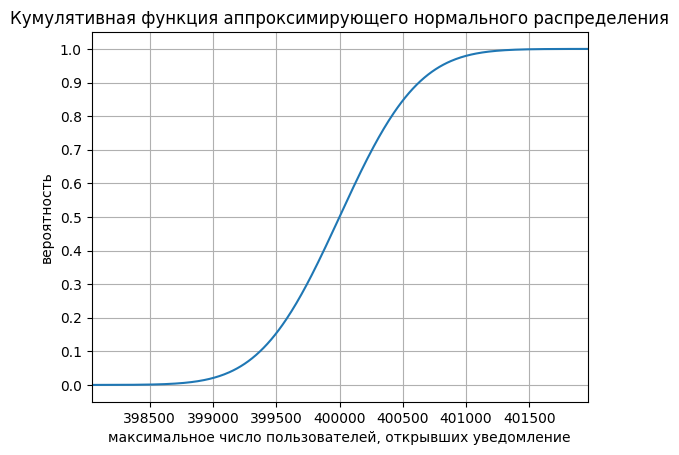

In [111]:
# строим и оформляем график кумулятивной функции вероятности
plt.plot(x, distr.cdf(x))
plt.xlim(left, right)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Кумулятивная функция аппроксимирующего нормального распределения')
plt.xlabel('максимальное число пользователей, открывших уведомление')
plt.ylabel('вероятность')
plt.grid()

Вероятность того, что количество пользователей $n$, открывших уведомление, составит не более $N$, будет равна значению кумулятивной функции вероятности $CDF(N)$:
$$P(n \le N) = CDF(N)$$

Таким образом, вероятность того, что уведомление откроют не более $m = 399500$ пользователей, будет равна $CDF(m)$.

In [112]:
# выводим ответ
print('Вероятность, что уведомление откроют '
      'не более {:.1f} тыс. пользователей, '
      'составляет {:.2%}.'
      .format(m / 1000, distr.cdf(m))
     )

Вероятность, что уведомление откроют не более 399.5 тыс. пользователей, составляет 15.37%.


**Вывод:**

Вероятность того, что при рассылке 1 млн push-уведомлений в мобильном приложении и вероятности открытия уведомления пользователем 40 %, полученное уведомление откроют не более 399,5 тыс. пользователей, составляет **примерно 15 %**.

###  Выводы

1. При условии, что после бесплатного пробного периода подписку продлевают 10 % пользователей, **минимальное количество промокодов**, которое нужно разослать, чтобы получить примерно равную 5 % вероятность не выполнить план акции, в рамках которой как минимум 100 существующих клиентов должны продлить подписку, составляет **1160**.

2. При рассылке 1 млн push-уведомлений в мобильном приложении и вероятности открытия уведомления пользователем 40% **вероятность того, что полученное уведомление откроют** не более 399,5 тыс. пользователей, составляет **примерно 15 %**.

## Общий вывод

1. **Обзор данных** показал, что качество полученных данных в целом высокое:
   - Пропущенные значения отсутствуют.
   - Имена столбцов во всех таблицах соответствуют общепринятому стилю именования.
   - Типы данных в столбцах таблиц соответствуют их характеру (кроме столбца с датой в таблице «Поездки»).
<br/><br/>

2. На этапе **предобработки** данные подготовлены для анализа:
    - **Изменён тип данных** даты совершения поездки в таблице «Поездки». Это позволит производить операции с датами и извлекать компоненты даты.
    - В таблице «Поездки» **добавлен новый столбец** с номером месяца совершения поездки. Это позволит удобно группировать поездки по месяцу из совершения.
    - **Удалены строки-дубликаты** в таблице «Пользователи». Они не несут полезной информации, а только могут исказить результаты анализа данных. Возможная причина их появления - **ошибки при выгрузке из базы данных**.
    - В таблицах «Пользователи» и «Подписки» **установлены столбцы индекса**, являющиеся ключами в этих таблицах - столбец `user_id` в таблице «Пользователи» и столбец `subscription_type` в таблице «Подписки».
<br/><br/>    

3. На этапе **исследовательского анализа** данных установлено:
    - В выборке представлены 8 городов, среди которых есть мегаполис - Москва, крупные города-региональные центры (Екатеринбург, Ростов-на-Дону, Омск, Краснодар), крупный город Сочи и относительно небольшой Пятигорск. **Распределение пользователей в выборке по городам примерно равномерное**: доли городов изменяются от ≈11 % (Москва) до ≈14 % (Пятигорск). Выборку можно считать репрезентативной, если число пользователей из определённого города в выборке пропорциональна общему числу пользователей сервиса в этом городе.

    - **Доли пользователей с подпиской и без подписки** в выборке не одинаковы, но отличаются не сильно - с подпиской ≈46 % пользователей, без подписки ≈54 % пользователей.  Отклонение от средней доли для отдельных городов лежит в пределах ± 5 %, причём для всех городов число пользователей с подпиской в выборке не превышает числа пользователей без подписки. Поэтому выборку можно считать достаточно репрезентативной.
  
    - **Средний возраст пользователей составляет 25 лет**. Распределение пользователей по возрасту похоже на нормальное. 

    - **Большинство поездок совершается на расстояние от 2 до 5 км**. Также выделяются **короткие поездки** на расстояния менее 1,5 км. Распределение поездок по расстоянию имеет вид суммы нормальных. Основной максимум распределения находится около 3 км, побочный максимум около 600-700 м соответствует коротким поездкам. Максимальное зафиксированное в выборке расстояние поездки составляет ≈7,2 км.

    - **Распределение поездок по продолжительности** похоже на нормальное с центром около 17-18 минут. Подавляющее большинство поездок по продолжительности попадают в диапазон от 2 до 35 минут.
       - Обнаруженные аномально короткие поездки с продолжительностью 0,5 минут - это случаи, когда пользователь отказался от совершения поездки. При этом расстояние таких поездок превышает 4 км. Возможно, при быстром завершении поездки в приложении происходит сбой геолокации. На это надо **обратить внимание разработчиков** приложения.
    
    - Максимальная **средняя скорость поездки** составляет чуть более 25 км/ч, что вполне реалистично. Большинство поездок совершается со средней скоростью от 6 до 16 км/ч, типичная скорость около 10 км/ч.
       - Обнаружены аномально медленные и поездки на близкие расстояния. Однако среди них нет заметных выбросов, скорость, расстояние и продолжительность изменяются плавно. Поэтому они оставлены в данных. Видимо, некоторые пользователи просто стояли на месте. Возможно, они столкнулись с техническими проблемами или препятствиями для движения. Либо это начинающие пользователи, которые пока только пробуют сервис и не освоили в достаточной мере использование приложения. 

    - Получены **распределения среднего расстояния и продолжительности поездки по пользователям**.
       - Распределение средней длины поездки по пользователям похоже на нормальное. В среднем по пользователям средняя длина поездки составляет ≈3,1 км. 
       - Распределение средней продолжительности поездки по пользователям также похоже на нормальное. В среднем по пользователям средняя продолжительность поездки составляет ≈18 минут.
<br/><br/> 

4. На этапе **объединения данных** данные о пользователях, поездках и подписках объединены в одну таблицу. Затем данные о пользователях с подпиской и без подписки выделены в отдельные таблицы. В результате анализа объединённых данных установлено:
    - Поездки распределены между городами практически так же, как и пользователи. Среднее число поездок на одного пользователя в зависимости от города меняется не значительно.
    - Количество поездок пользователей с подпиской в 1,8 раза меньше, чем у пользователей без подписки. Тем не менее, обе выборки достаточно велики.
    - Для обеих категорий пользователей **распределение поездок по расстоянию** имеет максимум около 3 км, но для пользователей с подпиской распределение существенно более узкое, чем для пользователей без подписки. Вероятно, **подписку обычно приобретают постоянные пользователи, совершающие регулярные поездки примерно на одно и то же расстояние**. Распределения расстояния поездок для обеих категорий пользователей имеют побочный максимум в области коротких поездок, но его положение отличается в зависимости от категории:
       - Для пользователей без подписки расстояние **коротких поездок** составляет менее 1 км, а максимум распределения находится около 500 м, причём значительна доля поездок на околонулевые расстояния. Вероятно, аномально короткие поездки совершают **начинающие пользователи**, которые пока только пробуют сервис и не освоили в достаточной мере использование приложения. 
       - Для пользователей с подпиской расстояние коротких поездок больше и составляет от 0,5 до 1,5 км с максимумом распределения около 1 км. Поездки на околонулевые расстояния отсутствуют. Это значит, что **пользователи с подпиской уверенно пользуются сервисом** для совершения поездок.
    
    - Для обеих категорий пользователей **распределения поездок по продолжительности** похоже на нормальное с центром около 18 минут. Величины разброса значений для обеих категорий пользователей отличаются не сильно.
        - **У пользователей без подписки бывают отказы от совершения поездки**, которые в данных проявляются как поездки с продолжительностью 0,5 мин. 
        - **У пользователей с подпиской отказов от поездки не наблюдается**. Это указывает на то, что пользователи с подпиской пользуются сервисом более осознанно.
        
    - Исследование **совместного распределения расстояния и продолжительности поездок** для пользователей обеих категорий по диаграммам рассеяния подтвердило наблюдения, сделанные ранее по гистограммам распределения расстояния и продолжительности поездок:
        - Поездки пользователей с подпиской сгруппированы более компактно, что говорит о **большей однородности группы пользователей с подпиской** в их сценариях использования сервиса.
        - Для обеих категорий пользователей есть обособленный кластер коротких поездок. Вероятно, есть **два типичных сценария использования сервиса** - для поездок на короткие расстояния в пределах микрорайона и более длинные поездки по городу.
        - Пользователи без подписки чаще совершают очень короткие и аномально медленные поездки. Видимо, это **поездки начинающих пользователей**, которые только пробуют сервис или испытывают трудности с его использованием.
        - **Минимальная допустимая продолжительность поездок** в сервисе составляет 2 минуты.
        - **Максимальная допустимая продолжительность поездок для пользователей без подписки** в сервисе составляет 35 минут.
        
    - **Средняя скорость поездок** оказалась близка для пользователей обеих категорий, но её разброс больше для пользователей без подписки. Это также говорит в пользу того, что **пользователи с подпиской в среднем более уверенно пользуются сервисом**, поддерживая оптимальную скорость движения.
<br/><br/> 

5. На этапе **агрегирования данных** о поездках для каждого пользователя за каждый месяц рассчитаны: 
    - суммарное количество поездок,
    - суммарное расстояние поездок,
    - суммарная продолжительность поездок,
    - суммарная выручка, которую принёс пользователь за месяц (помесячная выручка).
<br/><br/>
    
6. На этапе **проверки статистических гипотез** установлено:
    - **Средняя продолжительность поездок** пользователей с подпиской значимо больше средней продолжительности поездок пользователей без подписки.

    - **Среднее расстояние одной поездки** пользователей с подпиской не превышает 3130 м. Тем не менее, нельзя утверждать, что расстояние *всех* или по крайней мере *большинства* поездок не превышает 3130 м. Это утверждение будет верно только лишь для примерно половины всех поездок.

    - При уровне статистической значимости 0.05 для всех месяцев года **средняя помесячная выручка от пользователя** с подпиской значимо больше средней помесячной выручки от пользователя без подписки. Однако при выборе уровня статистической значимости 0.01 для марта уже нельзя отвергнуть нулевую гипотезу о равенстве помесячной выручки для пользователей обеих категорий в пользу альтернативной гипотезы о том, что от пользователей с подпиской помесячная выручка больше. Поэтому значимость вывода по результатам проверки гипотезы за этот месяц меньше, чем для других месяцев года.
    - Для проверки гипотезы о том, **снизилось ли количество обращений в техподдержку** после обновления серверов, с которыми взаимодействует мобильное приложение, нужно использовать односторонний двухвыборочный t-тест для зависимых (парных) выборок с альтернативной гипотезой, что количество обращений в техподдержку после обновления стало меньше.
<br/><br/>    
    
7. На последнем этапе **планирования маркетинговых акций** установлено:
    - При условии, что после бесплатного пробного периода подписку продлевают 10 % пользователей, **минимальное количество промокодов**, которое нужно разослать, чтобы получить примерно равную 5 % вероятность не выполнить план акции, в рамках которой как минимум 100 существующих клиентов должны продлить подписку, составляет **1160**.

    - При рассылке 1 млн push-уведомлений в мобильном приложении и вероятности открытия уведомления пользователем 40 % **вероятность того, что полученное уведомление откроют** не более 399,5 тыс. пользователей, составляет **примерно 15 %**.